## Setup and Imports

In [226]:
# Install required packages if not available
import subprocess
import sys

packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scipy', 'statsmodels', 'nltk', 'scikit-learn', 'spacy']
for package in packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '-q'])

# Download spaCy English model
try:
    import spacy
    spacy.load('en_core_web_sm')
except:
    subprocess.check_call([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm', '-q'])

print("All packages installed successfully!")


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


All packages installed successfully!


In [227]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import spacy
import warnings
warnings.filterwarnings('ignore')

# Load spaCy English model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries imported successfully!")
print(f"Using spaCy model: {nlp.meta['name']} v{nlp.meta['version']}")

Libraries imported successfully!
Using spaCy model: core_web_sm v3.8.0


## Data Loading

In [228]:
# Define file paths
BASE_PATH = '/home/krishiv/naturalstories'

# Load Reading Times data
rt_df = pd.read_csv(f'{BASE_PATH}/naturalstories_RTS/processed_RTs.tsv', sep='\t')
print(f"Reading Times data shape: {rt_df.shape}")
print(f"Columns: {rt_df.columns.tolist()}")
rt_df.head()

Reading Times data shape: (848875, 12)
Columns: ['WorkerId', 'WorkTimeInSeconds', 'correct', 'item', 'zone', 'RT', 'word', 'nItem', 'meanItemRT', 'sdItemRT', 'gmeanItemRT', 'gsdItemRT']


,WorkerId,WorkTimeInSeconds,correct,item,zone,RT,word,nItem,meanItemRT,sdItemRT,gmeanItemRT,gsdItemRT
0,A3QJPB0NZU5PY1,3960,6,1,1,637,If,84,578.964286,276.061345,527.81264,1.524238
1,A2RPQGUWVZPX7U,2431,5,1,1,1222,If,84,578.964286,276.061345,527.81264,1.524238
2,A11KMPAZSE5Q0Q,1287,5,1,1,416,If,84,578.964286,276.061345,527.81264,1.524238
3,A1U1QL617G5DU3,2074,6,1,1,571,If,84,578.964286,276.061345,527.81264,1.524238
4,ACTW5YEWV9OR0,2213,6,1,1,1208,If,84,578.964286,276.061345,527.81264,1.524238


In [229]:
# Load word frequency data (unigram frequencies)
freq_df = pd.read_csv(f'{BASE_PATH}/freqs/freqs-1.tsv', sep='\t', header=None,
                      names=['token_code', 'ngram_order', 'word', 'frequency', 'prev_freq'])
print(f"Frequency data shape: {freq_df.shape}")
freq_df.head()

Frequency data shape: (32342, 5)


,token_code,ngram_order,word,frequency,prev_freq
0,1.1.whole,1,If,123141271,NaN
1,1.1.word,1,If,123141271,NaN
2,1.1.1,1,If,123141271,NaN
3,1.2.whole,1,you,578117187,NaN
4,1.2.word,1,you,578117187,NaN


In [230]:
# Load GPT-3 probabilities
gpt3_df = pd.read_csv(f'{BASE_PATH}/probs/all_stories_gpt3.csv')
print(f"GPT-3 probabilities data shape: {gpt3_df.shape}")
gpt3_df.head()

GPT-3 probabilities data shape: (12373, 7)


,token,logprob,offset,model,time,id,story
0,If,NaN,0,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,0
1,you,-0.776271,2,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,0
2,were,-4.331911,6,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,0
3,to,-1.461822,11,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,0
4,journey,-10.098377,14,davinci:2020-05-03,1614358345,cmpl-2XadldozPyY3qBl3GxvbDAX8XOE6V,0


In [231]:
# Load story tokens for alignment
stories_df = pd.read_csv(f'{BASE_PATH}/naturalstories_RTS/all_stories.tok', sep='\t')
print(f"Stories data shape: {stories_df.shape}")
stories_df.head()

Stories data shape: (10256, 3)


,word,zone,item
0,If,1,1
1,you,2,1
2,were,3,1
3,to,4,1
4,journey,5,1


---
# Part I: Preliminary Data Analysis

## Question 1: Compute Mean RT per Word
For each word in the RT file, compute the average reading time (RT) across all subjects.

In [232]:
# Group by item (story) and zone (word position) to get mean RT per word
mean_rt_per_word = rt_df.groupby(['item', 'zone', 'word']).agg({
    'RT': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
mean_rt_per_word.columns = ['item', 'zone', 'word', 'mean_RT', 'std_RT', 'n_subjects']

print(f"Number of unique words (by position): {len(mean_rt_per_word)}")
print(f"\nSummary statistics for Mean RT:")
print(mean_rt_per_word['mean_RT'].describe())
mean_rt_per_word.head()

Number of unique words (by position): 10256

Summary statistics for Mean RT:
count    10256.000000
mean       338.174687
std         42.043142
min        256.863014
25%        311.406009
50%        330.073466
75%        355.403274
max        873.114286
Name: mean_RT, dtype: float64


,item,zone,word,mean_RT,std_RT,n_subjects
0,1,1,If,578.964286,276.061345,84
1,1,2,you,369.011905,160.579935,84
2,1,3,were,368.183908,168.027166,87
3,1,4,to,344.318182,224.916666,88
4,1,5,journey,354.639535,310.065644,86


In [233]:
# Add word length column
mean_rt_per_word['word_length'] = mean_rt_per_word['word'].str.len()

# Clean the word column (remove punctuation for matching)
mean_rt_per_word['word_clean'] = mean_rt_per_word['word'].str.replace(r'[^\w\s]', '', regex=True).str.lower()

print(f"Word length range: {mean_rt_per_word['word_length'].min()} - {mean_rt_per_word['word_length'].max()}")
mean_rt_per_word.head()

Word length range: 1 - 23


,item,zone,word,mean_RT,std_RT,n_subjects,word_length,word_clean
0,1,1,If,578.964286,276.061345,84,2,if
1,1,2,you,369.011905,160.579935,84,3,you
2,1,3,were,368.183908,168.027166,87,4,were
3,1,4,to,344.318182,224.916666,88,2,to
4,1,5,journey,354.639535,310.065644,86,7,journey


## Merge Frequency Data with RT Data

In [234]:
# Filter frequency data to get only "word" tokenization (no punctuation)
freq_word = freq_df[freq_df['token_code'].str.contains('.word', regex=False)].copy()

# Extract story and zone from token_code
freq_word['item'] = freq_word['token_code'].str.split('.').str[0].astype(int)
freq_word['zone'] = freq_word['token_code'].str.split('.').str[1].astype(int)

# Rename columns
freq_word = freq_word[['item', 'zone', 'word', 'frequency']].copy()
freq_word.columns = ['item', 'zone', 'freq_word', 'word_frequency']

print(f"Frequency data (filtered) shape: {freq_word.shape}")
freq_word.head()

Frequency data (filtered) shape: (10246, 4)


,item,zone,freq_word,word_frequency
1,1,1,If,123141271
4,1,2,you,578117187
7,1,3,were,457504590
10,1,4,to,4223327232
13,1,5,journey,6826751


In [235]:
# Merge RT data with frequency data
merged_df = mean_rt_per_word.merge(freq_word, on=['item', 'zone'], how='left')

# Convert frequency to numeric and handle missing values
merged_df['word_frequency'] = pd.to_numeric(merged_df['word_frequency'], errors='coerce')

# Add log frequency (common in psycholinguistics)
merged_df['log_frequency'] = np.log10(merged_df['word_frequency'] + 1)

print(f"Merged data shape: {merged_df.shape}")
print(f"Missing frequency values: {merged_df['word_frequency'].isna().sum()}")
merged_df.head()

Merged data shape: (10256, 11)
Missing frequency values: 10


,item,zone,word,mean_RT,std_RT,n_subjects,word_length,word_clean,freq_word,word_frequency,log_frequency
0,1,1,If,578.964286,276.061345,84,2,if,If,1.231413e+08,8.090404
1,1,2,you,369.011905,160.579935,84,3,you,you,5.781172e+08,8.762016
2,1,3,were,368.183908,168.027166,87,4,were,were,4.575046e+08,8.660395
3,1,4,to,344.318182,224.916666,88,2,to,to,4.223327e+09,9.625655
4,1,5,journey,354.639535,310.065644,86,7,journey,journey,6.826751e+06,6.834214


## Merge GPT-3 Probabilities

In [236]:
# Process GPT-3 data - Handle subword tokenization
# GPT-3 uses BPE which splits words into subwords (e.g., "moors" -> ["mo", "ors"])
# We need to reconstruct full words and aggregate their surprisals

gpt3_df['story'] = gpt3_df['story'] + 1  # Convert 0-indexed to 1-indexed
gpt3_df['logprob'] = pd.to_numeric(gpt3_df['logprob'], errors='coerce')
gpt3_df['surprisal'] = -gpt3_df['logprob']

# Tokens starting with a space indicate the START of a new word
# Tokens without leading space are continuations (subwords)
gpt3_df['is_word_start'] = gpt3_df['token'].str.startswith(' ') | (gpt3_df.groupby('story').cumcount() == 0)

# Create word groups within each story
gpt3_df['word_group'] = gpt3_df.groupby('story')['is_word_start'].cumsum()

# Aggregate subwords into full words
# Concatenate tokens and sum surprisals (joint probability = product, so sum of log probs)
gpt3_words_agg = gpt3_df.groupby(['story', 'word_group']).agg({
    'token': lambda x: ''.join(x).strip(),  # Concatenate and strip
    'surprisal': 'sum',  # Sum of surprisals = -log(product of probs)
    'logprob': 'sum'
}).reset_index()

gpt3_words_agg.columns = ['story', 'word_group', 'full_token', 'total_surprisal', 'total_logprob']

# Clean the token
gpt3_words_agg['token_clean'] = gpt3_words_agg['full_token'].str.lower().str.replace(r'[^\w]', '', regex=True)

# Add word position within story
gpt3_words_agg['position'] = gpt3_words_agg.groupby('story').cumcount() + 1

print(f"GPT-3 reconstructed words: {len(gpt3_words_agg)}")
print(f"\nSample of reconstructed words (Story 1):")
print(gpt3_words_agg[gpt3_words_agg['story']==1][['story', 'position', 'full_token', 'total_surprisal']].head(25).to_string(index=False))

GPT-3 reconstructed words: 10256

Sample of reconstructed words (Story 1):
 story  position full_token  total_surprisal
     1         1         If         0.000000
     1         2        you         0.776271
     1         3       were         4.331911
     1         4         to         1.461822
     1         5    journey        10.098377
     1         6         to         1.281663
     1         7        the         0.959809
     1         8      North         4.631145
     1         9         of         3.359971
     1        10   England,         2.544441
     1        11        you         0.960976
     1        12      would         0.940191
     1        13       come         3.179864
     1        14         to         1.934601
     1        15          a         0.994034
     1        16     valley         5.733325
     1        17       that         2.337450
     1        18         is         1.378344
     1        19 surrounded         2.561977
     1        20         

In [237]:
# Merge GPT-3 data with main dataframe by position
gpt3_subset = gpt3_words_agg[['story', 'position', 'total_logprob', 'total_surprisal', 'token_clean', 'full_token']].copy()
gpt3_subset.columns = ['item', 'zone', 'gpt3_logprob', 'gpt3_surprisal', 'gpt3_token_clean', 'gpt3_token']

merged_df = merged_df.merge(gpt3_subset, on=['item', 'zone'], how='left')

# Verify alignment
merged_df['word_clean_lower'] = merged_df['word_clean'].str.lower()
merged_df['align_match'] = merged_df['word_clean_lower'] == merged_df['gpt3_token_clean']
match_rate = merged_df['align_match'].mean() * 100

print(f"Final merged data shape: {merged_df.shape}")
print(f"Missing GPT-3 values: {merged_df['gpt3_surprisal'].isna().sum()}")
print(f"\n*** Alignment match rate: {match_rate:.1f}% ***")

# Show alignment for Story 1
print("\nAlignment verification (Story 1):")
sample = merged_df[merged_df['item']==1][['zone', 'word', 'gpt3_token', 'align_match', 'mean_RT', 'gpt3_surprisal']].head(25)
print(sample.to_string(index=False))

merged_df.head()

Final merged data shape: (10256, 17)
Missing GPT-3 values: 0

*** Alignment match rate: 100.0% ***

Alignment verification (Story 1):
 zone       word gpt3_token  align_match    mean_RT  gpt3_surprisal
    1         If         If         True 578.964286        0.000000
    2        you        you         True 369.011905        0.776271
    3       were       were         True 368.183908        4.331911
    4         to         to         True 344.318182        1.461822
    5    journey    journey         True 354.639535       10.098377
    6         to         to         True 349.674157        1.281663
    7        the        the         True 376.370787        0.959809
    8      North      North         True 327.310345        4.631145
    9         of         of         True 365.494382        3.359971
   10   England,   England,         True 344.931034        2.544441
   11        you        you         True 400.269663        0.960976
   12      would      would         True 372.59090

,item,zone,word,mean_RT,std_RT,n_subjects,word_length,word_clean,freq_word,word_frequency,log_frequency,gpt3_logprob,gpt3_surprisal,gpt3_token_clean,gpt3_token,word_clean_lower,align_match
0,1,1,If,578.964286,276.061345,84,2,if,If,1.231413e+08,8.090404,0.000000,0.000000,if,If,if,True
1,1,2,you,369.011905,160.579935,84,3,you,you,5.781172e+08,8.762016,-0.776271,0.776271,you,you,you,True
2,1,3,were,368.183908,168.027166,87,4,were,were,4.575046e+08,8.660395,-4.331911,4.331911,were,were,were,True
3,1,4,to,344.318182,224.916666,88,2,to,to,4.223327e+09,9.625655,-1.461822,1.461822,to,to,to,True
4,1,5,journey,354.639535,310.065644,86,7,journey,journey,6.826751e+06,6.834214,-10.098377,10.098377,journey,journey,journey,True


In [238]:
# Create a clean dataset for analysis (remove missing values)
analysis_df = merged_df.dropna(subset=['mean_RT', 'word_frequency', 'gpt3_surprisal']).copy()
analysis_df = analysis_df[analysis_df['word_frequency'] > 0].copy()

print(f"Analysis dataset shape: {analysis_df.shape}")
print(f"\nDataset summary:")
analysis_df[['mean_RT', 'word_length', 'log_frequency', 'gpt3_surprisal']].describe()

Analysis dataset shape: (10238, 17)

Dataset summary:


,mean_RT,word_length,log_frequency,gpt3_surprisal
count,10238.000000,10238.000000,10238.000000,10238.000000
mean,338.008363,4.576968,7.935774,2.440988
std,41.567991,2.383863,1.374594,2.510391
min,256.863014,1.000000,1.770852,0.000000
25%,311.366930,3.000000,6.977079,0.532600
50%,329.971618,4.000000,8.052416,1.655609
75%,355.300000,6.000000,9.045348,3.567966
max,873.114286,22.000000,9.992109,20.709197


## Question 2: Word Length vs Mean RT

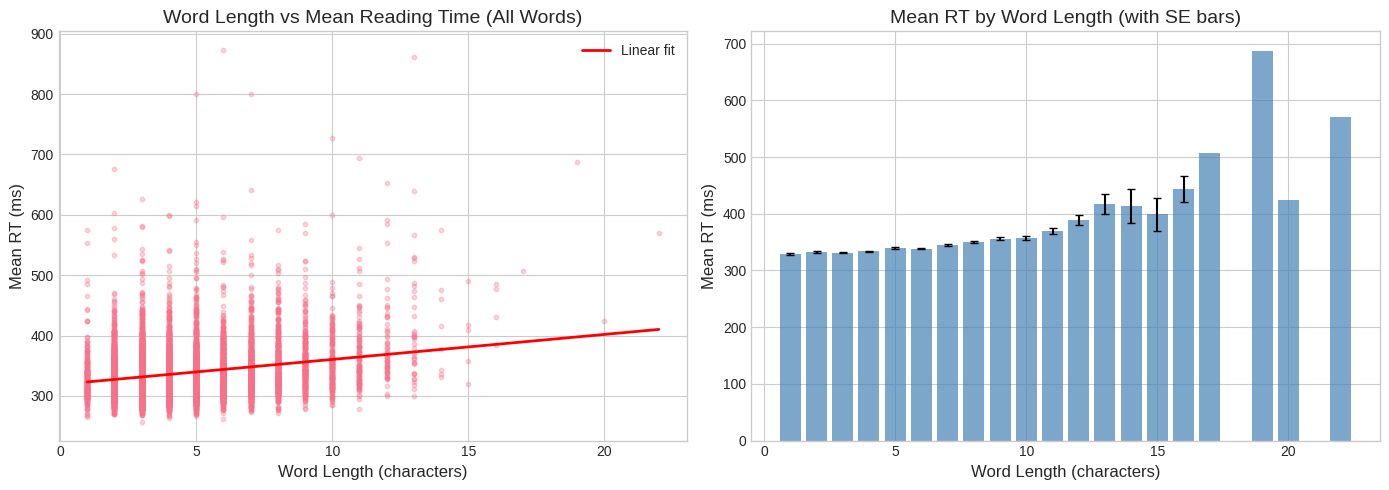


Mean RT by Word Length:
 word_length    mean_RT     std_RT  count
           1 329.032929  39.095968    275
           2 332.599846  34.923083   1450
           3 331.019712  35.652695   2492
           4 333.751576  35.471905   1820
           5 339.534959  43.314937   1240
           6 338.420508  40.307170    935
           7 344.988506  44.854926    748
           8 350.525544  43.380762    524
           9 356.042297  45.353825    316
          10 356.753411  50.501907    204
          11 369.965272  59.387837    116
          12 389.097741  71.048746     60
          13 417.558952 109.052039     37
          14 414.390748  85.328047      8
          15 398.908216  64.817760      5
          16 444.294346  46.209396      4
          17 507.375000        NaN      1
          19 687.366197        NaN      1
          20 423.442857        NaN      1
          22 569.882353        NaN      1


In [239]:
# Calculate mean RT by word length
rt_by_length = analysis_df.groupby('word_length').agg({
    'mean_RT': ['mean', 'std', 'count']
}).reset_index()
rt_by_length.columns = ['word_length', 'mean_RT', 'std_RT', 'count']

# Plot: Word Length vs Mean RT
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
ax1 = axes[0]
ax1.scatter(analysis_df['word_length'], analysis_df['mean_RT'], alpha=0.3, s=10)
z = np.polyfit(analysis_df['word_length'], analysis_df['mean_RT'], 1)
p = np.poly1d(z)
x_line = np.linspace(analysis_df['word_length'].min(), analysis_df['word_length'].max(), 100)
ax1.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Linear fit')
ax1.set_xlabel('Word Length (characters)', fontsize=12)
ax1.set_ylabel('Mean RT (ms)', fontsize=12)
ax1.set_title('Word Length vs Mean Reading Time (All Words)', fontsize=14)
ax1.legend()

# Bar plot with error bars (aggregated by length)
ax2 = axes[1]
rt_by_length_filtered = rt_by_length[rt_by_length['count'] >0]  # Filter for sufficient data
ax2.bar(rt_by_length_filtered['word_length'], rt_by_length_filtered['mean_RT'], 
        yerr=rt_by_length_filtered['std_RT']/np.sqrt(rt_by_length_filtered['count']),
        capsize=3, alpha=0.7, color='steelblue')
ax2.set_xlabel('Word Length (characters)', fontsize=12)
ax2.set_ylabel('Mean RT (ms)', fontsize=12)
ax2.set_title('Mean RT by Word Length (with SE bars)', fontsize=14)

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/plot_length_vs_rt.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMean RT by Word Length:")
print(rt_by_length_filtered.to_string(index=False))

## Question 3: Word Frequency vs Mean RT

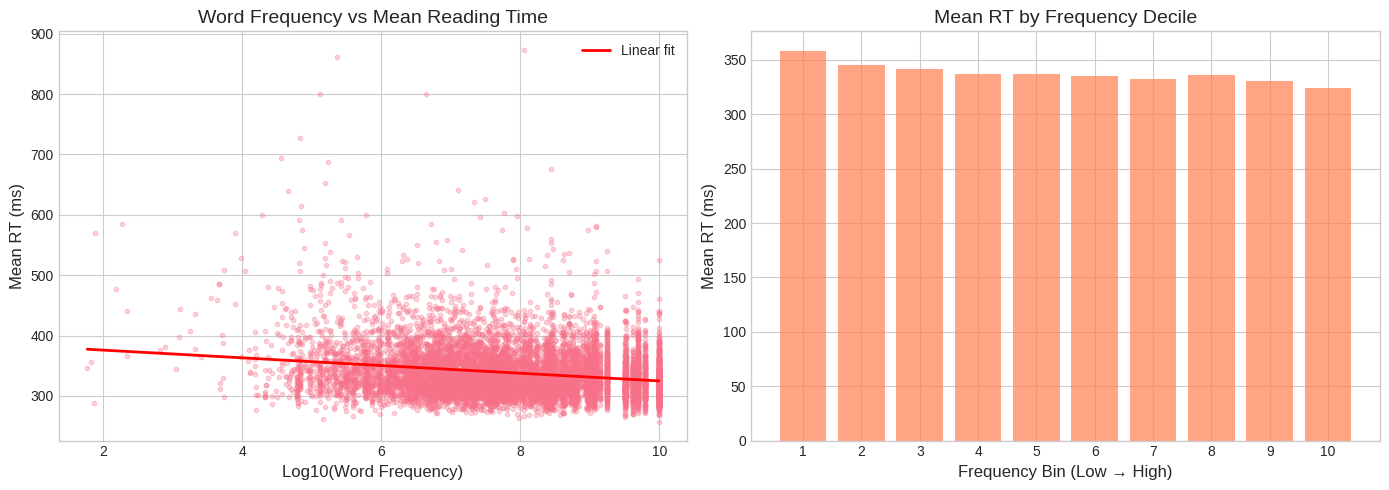

In [240]:
# Plot: Word Frequency vs Mean RT
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with log frequency
ax1 = axes[0]
ax1.scatter(analysis_df['log_frequency'], analysis_df['mean_RT'], alpha=0.3, s=10)
z = np.polyfit(analysis_df['log_frequency'], analysis_df['mean_RT'], 1)
p = np.poly1d(z)
x_line = np.linspace(analysis_df['log_frequency'].min(), analysis_df['log_frequency'].max(), 100)
ax1.plot(x_line, p(x_line), 'r-', linewidth=2, label='Linear fit')
ax1.set_xlabel('Log10(Word Frequency)', fontsize=12)
ax1.set_ylabel('Mean RT (ms)', fontsize=12)
ax1.set_title('Word Frequency vs Mean Reading Time', fontsize=14)
ax1.legend()

# Create frequency bins for visualization
analysis_df['freq_bin'] = pd.qcut(analysis_df['log_frequency'], q=10, labels=False, duplicates='drop')
rt_by_freq_bin = analysis_df.groupby('freq_bin').agg({
    'mean_RT': 'mean',
    'log_frequency': 'mean'
}).reset_index()

ax2 = axes[1]
ax2.bar(range(len(rt_by_freq_bin)), rt_by_freq_bin['mean_RT'], alpha=0.7, color='coral')
ax2.set_xlabel('Frequency Bin (Low → High)', fontsize=12)
ax2.set_ylabel('Mean RT (ms)', fontsize=12)
ax2.set_title('Mean RT by Frequency Decile', fontsize=14)
ax2.set_xticks(range(len(rt_by_freq_bin)))
ax2.set_xticklabels([f'{i+1}' for i in range(len(rt_by_freq_bin))])

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/plot_frequency_vs_rt.png', dpi=150, bbox_inches='tight')
plt.show()

## Questions 4-6: Pearson Correlation Coefficients

In [241]:
# Question 4: Correlation between Length and Frequency
corr_length_freq, p_length_freq = pearsonr(analysis_df['word_length'], analysis_df['log_frequency'])
print("="*60)
print("QUESTION 4: Correlation between Word Length and Frequency")
print("="*60)
print(f"Pearson's r = {corr_length_freq:.4f}")
print(f"p-value = {p_length_freq:.2e}")
print(f"Interpretation: {'Significant' if p_length_freq < 0.05 else 'Not significant'} correlation")

QUESTION 4: Correlation between Word Length and Frequency
Pearson's r = -0.7193
p-value = 0.00e+00
Interpretation: Significant correlation


In [242]:
# Question 5: Correlation between Word Length and Mean RT
corr_length_rt, p_length_rt = pearsonr(analysis_df['word_length'], analysis_df['mean_RT'])
print("="*60)
print("QUESTION 5: Correlation between Word Length and Mean RT")
print("="*60)
print(f"Pearson's r = {corr_length_rt:.4f}")
print(f"p-value = {p_length_rt:.2e}")
print(f"Interpretation: {'Significant' if p_length_rt < 0.05 else 'Not significant'} correlation")

QUESTION 5: Correlation between Word Length and Mean RT
Pearson's r = 0.2376
p-value = 2.35e-131
Interpretation: Significant correlation


In [243]:
# Question 6: Correlation between Word Frequency and Mean RT
corr_freq_rt, p_freq_rt = pearsonr(analysis_df['log_frequency'], analysis_df['mean_RT'])
print("="*60)
print("QUESTION 6: Correlation between Word Frequency and Mean RT")
print("="*60)
print(f"Pearson's r = {corr_freq_rt:.4f}")
print(f"p-value = {p_freq_rt:.2e}")
print(f"Interpretation: {'Significant' if p_freq_rt < 0.05 else 'Not significant'} correlation")

QUESTION 6: Correlation between Word Frequency and Mean RT
Pearson's r = -0.2111
p-value = 1.74e-103
Interpretation: Significant correlation


## Part I Summary

In [244]:
print("="*70)
print("PART I SUMMARY: Relationship between Word Length, Frequency, and RT")
print("="*70)
print(f"""
1. WORD LENGTH AND READING TIME (r = {corr_length_rt:.4f}, p < 0.001):
   - Positive correlation: Longer words take more time to read
   - This reflects the visual processing time required for more characters

2. WORD FREQUENCY AND READING TIME (r = {corr_freq_rt:.4f}, p < 0.001):
   - Negative correlation: More frequent words are read faster
   - This is the well-known "word frequency effect" in psycholinguistics
   - High-frequency words have stronger lexical representations

3. WORD LENGTH AND FREQUENCY (r = {corr_length_freq:.4f}, p < 0.001):
   - Negative correlation: Shorter words tend to be more frequent
   - This follows Zipf's law of abbreviation

CONCLUSION:
Both word length and frequency are significant predictors of reading time.
Longer words take more time to process (visual/motor demands), while
frequent words are processed faster (lexical access). The negative
correlation between length and frequency means these effects partially
confound each other, necessitating regression models to isolate effects.
""")

PART I SUMMARY: Relationship between Word Length, Frequency, and RT

1. WORD LENGTH AND READING TIME (r = 0.2376, p < 0.001):
   - Positive correlation: Longer words take more time to read
   - This reflects the visual processing time required for more characters

2. WORD FREQUENCY AND READING TIME (r = -0.2111, p < 0.001):
   - Negative correlation: More frequent words are read faster
   - This is the well-known "word frequency effect" in psycholinguistics
   - High-frequency words have stronger lexical representations

3. WORD LENGTH AND FREQUENCY (r = -0.7193, p < 0.001):
   - Negative correlation: Shorter words tend to be more frequent
   - This follows Zipf's law of abbreviation

CONCLUSION:
Both word length and frequency are significant predictors of reading time.
Longer words take more time to process (visual/motor demands), while
frequent words are processed faster (lexical access). The negative
correlation between length and frequency means these effects partially
confound eac

---
# Part II: Hypothesis Testing

## Hypothesis 1: LM Probabilities vs Word Frequency as RT Predictors

In [245]:
# Prepare data for regression
regression_df = analysis_df[['mean_RT', 'word_length', 'log_frequency', 'gpt3_surprisal']].dropna()

# Standardize predictors for comparison
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
regression_df[['word_length_z', 'log_frequency_z', 'surprisal_z']] = scaler.fit_transform(
    regression_df[['word_length', 'log_frequency', 'gpt3_surprisal']]
)

print(f"Regression dataset size: {len(regression_df)}")
regression_df.head()

Regression dataset size: 10238


,mean_RT,word_length,log_frequency,gpt3_surprisal,word_length_z,log_frequency_z,surprisal_z
0,578.964286,2,8.090404,0.000000,-1.081058,0.112496,-0.972401
1,369.011905,3,8.762016,0.776271,-0.661550,0.601110,-0.663163
2,368.183908,4,8.660395,4.331911,-0.242043,0.527179,0.753275
3,344.318182,2,9.625655,1.461822,-1.081058,1.229427,-0.390064
4,354.639535,7,6.834214,10.098377,1.016480,-0.801411,3.050426


In [246]:
# Model 1: Mean RT ~ Word Frequency + Word Length
print("="*70)
print("MODEL 1: Mean RT ~ Word Frequency + Word Length")
print("="*70)

model1 = ols('mean_RT ~ log_frequency + word_length', data=regression_df).fit()
print(model1.summary())

MODEL 1: Mean RT ~ Word Frequency + Word Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     325.5
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          9.08e-138
Time:                        11:40:39   Log-Likelihood:                -52371.
No. Observations:               10238   AIC:                         1.047e+05
Df Residuals:                   10235   BIC:                         1.048e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [247]:
# Model 2: Mean RT ~ GPT-3 Surprisal + Word Length
print("="*70)
print("MODEL 2: Mean RT ~ -log(GPT-3 probability) + Word Length")
print("="*70)

model2 = ols('mean_RT ~ gpt3_surprisal + word_length', data=regression_df).fit()
print(model2.summary())

MODEL 2: Mean RT ~ -log(GPT-3 probability) + Word Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     370.7
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          3.73e-156
Time:                        11:40:39   Log-Likelihood:                -52329.
No. Observations:               10238   AIC:                         1.047e+05
Df Residuals:                   10235   BIC:                         1.047e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [248]:
# Compare models
print("="*70)
print("MODEL COMPARISON: Hypothesis 1")
print("="*70)
print(f"""
                          Model 1 (Frequency)    Model 2 (GPT-3 Surprisal)
{'─'*70}
R-squared:                {model1.rsquared:.4f}                    {model2.rsquared:.4f}
Adjusted R-squared:       {model1.rsquared_adj:.4f}                    {model2.rsquared_adj:.4f}
AIC:                      {model1.aic:.2f}                 {model2.aic:.2f}
BIC:                      {model1.bic:.2f}                 {model2.bic:.2f}
""")

if model2.rsquared > model1.rsquared:
    print("CONCLUSION: Model 2 (GPT-3 Surprisal) has HIGHER R² than Model 1 (Frequency)")
    print("→ Language model probabilities are BETTER predictors of reading time.")
else:
    print("CONCLUSION: Model 1 (Frequency) has HIGHER R² than Model 2 (GPT-3 Surprisal)")
    print("→ Word frequency is a BETTER predictor of reading time.")

MODEL COMPARISON: Hypothesis 1

                          Model 1 (Frequency)    Model 2 (GPT-3 Surprisal)
──────────────────────────────────────────────────────────────────────
R-squared:                0.0598                    0.0675
Adjusted R-squared:       0.0596                    0.0674
AIC:                      104748.72                 104664.02
BIC:                      104770.42                 104685.72

CONCLUSION: Model 2 (GPT-3 Surprisal) has HIGHER R² than Model 1 (Frequency)
→ Language model probabilities are BETTER predictors of reading time.


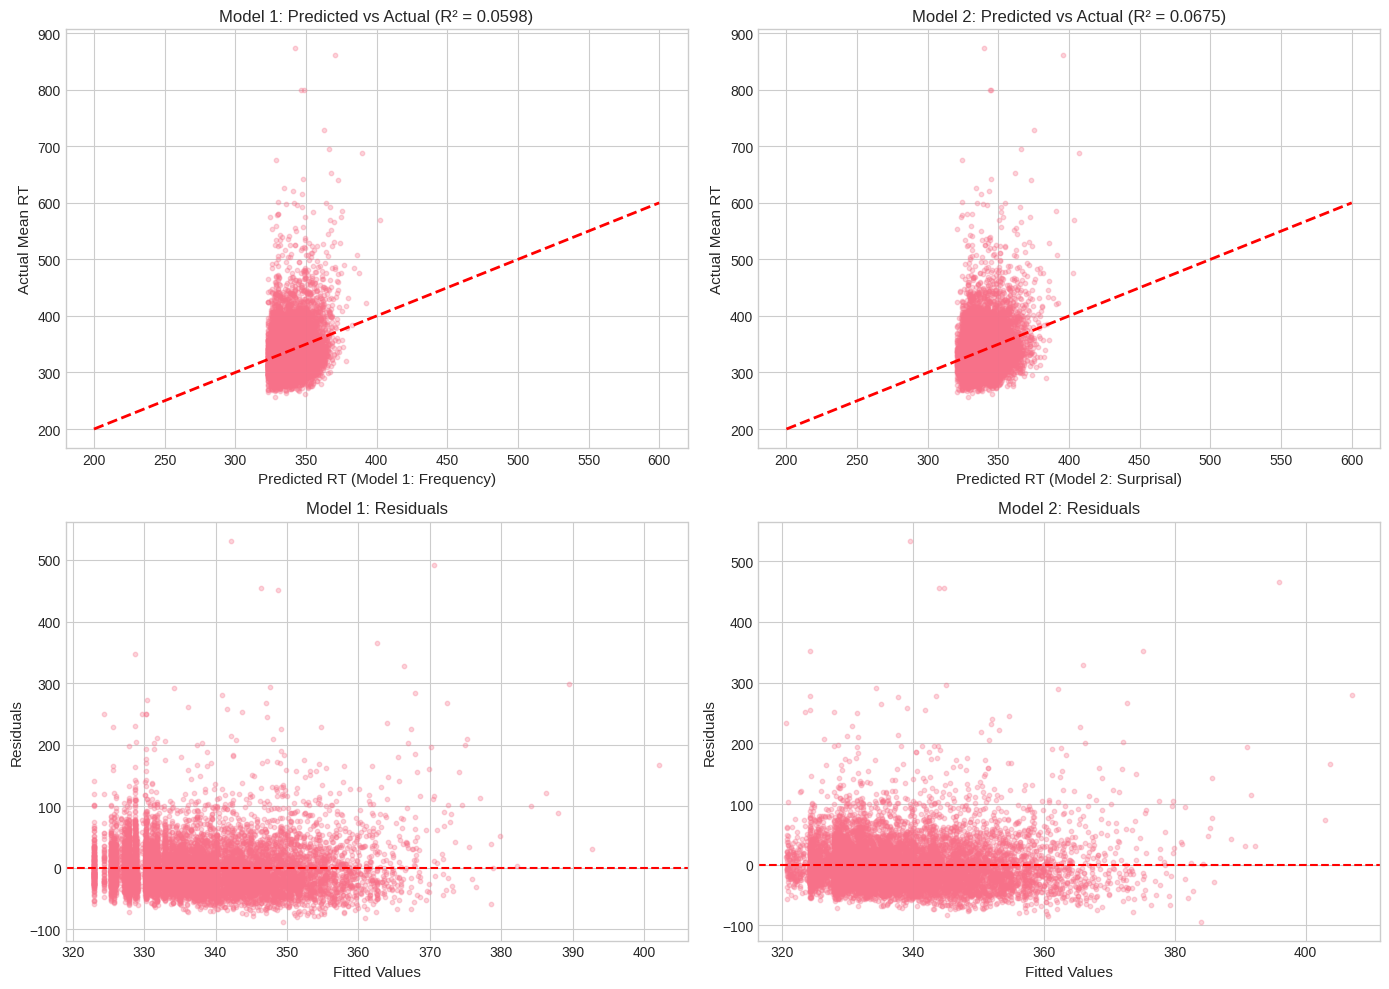

In [249]:
# Visualization for Hypothesis 1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Predicted vs Actual for Model 1
ax1 = axes[0, 0]
ax1.scatter(model1.fittedvalues, regression_df['mean_RT'], alpha=0.3, s=10)
ax1.plot([200, 600], [200, 600], 'r--', linewidth=2)
ax1.set_xlabel('Predicted RT (Model 1: Frequency)', fontsize=11)
ax1.set_ylabel('Actual Mean RT', fontsize=11)
ax1.set_title(f'Model 1: Predicted vs Actual (R² = {model1.rsquared:.4f})', fontsize=12)

# Predicted vs Actual for Model 2
ax2 = axes[0, 1]
ax2.scatter(model2.fittedvalues, regression_df['mean_RT'], alpha=0.3, s=10)
ax2.plot([200, 600], [200, 600], 'r--', linewidth=2)
ax2.set_xlabel('Predicted RT (Model 2: Surprisal)', fontsize=11)
ax2.set_ylabel('Actual Mean RT', fontsize=11)
ax2.set_title(f'Model 2: Predicted vs Actual (R² = {model2.rsquared:.4f})', fontsize=12)

# Residuals for Model 1
ax3 = axes[1, 0]
ax3.scatter(model1.fittedvalues, model1.resid, alpha=0.3, s=10)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Fitted Values', fontsize=11)
ax3.set_ylabel('Residuals', fontsize=11)
ax3.set_title('Model 1: Residuals', fontsize=12)

# Residuals for Model 2
ax4 = axes[1, 1]
ax4.scatter(model2.fittedvalues, model2.resid, alpha=0.3, s=10)
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Fitted Values', fontsize=11)
ax4.set_ylabel('Residuals', fontsize=11)
ax4.set_title('Model 2: Residuals', fontsize=12)

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/hypothesis1_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

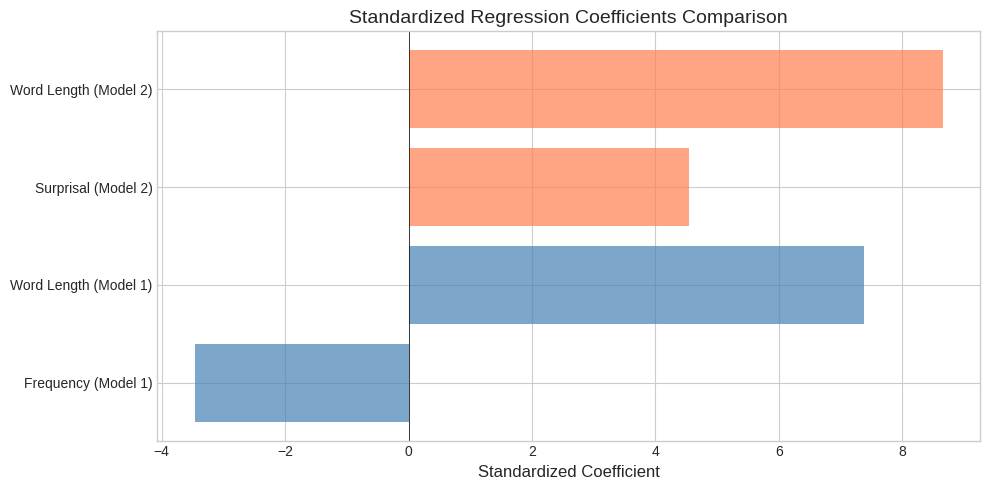

In [250]:
# Coefficient comparison visualization
fig, ax = plt.subplots(figsize=(10, 5))

# Use standardized coefficients for comparison
model1_z = ols('mean_RT ~ log_frequency_z + word_length_z', data=regression_df).fit()
model2_z = ols('mean_RT ~ surprisal_z + word_length_z', data=regression_df).fit()

coef_data = pd.DataFrame({
    'Predictor': ['Frequency (Model 1)', 'Word Length (Model 1)', 'Surprisal (Model 2)', 'Word Length (Model 2)'],
    'Coefficient': [model1_z.params['log_frequency_z'], model1_z.params['word_length_z'],
                   model2_z.params['surprisal_z'], model2_z.params['word_length_z']],
    'Model': ['Model 1', 'Model 1', 'Model 2', 'Model 2']
})

colors = ['steelblue', 'steelblue', 'coral', 'coral']
bars = ax.barh(coef_data['Predictor'], coef_data['Coefficient'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Standardized Coefficient', fontsize=12)
ax.set_title('Standardized Regression Coefficients Comparison', fontsize=14)

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/hypothesis1_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

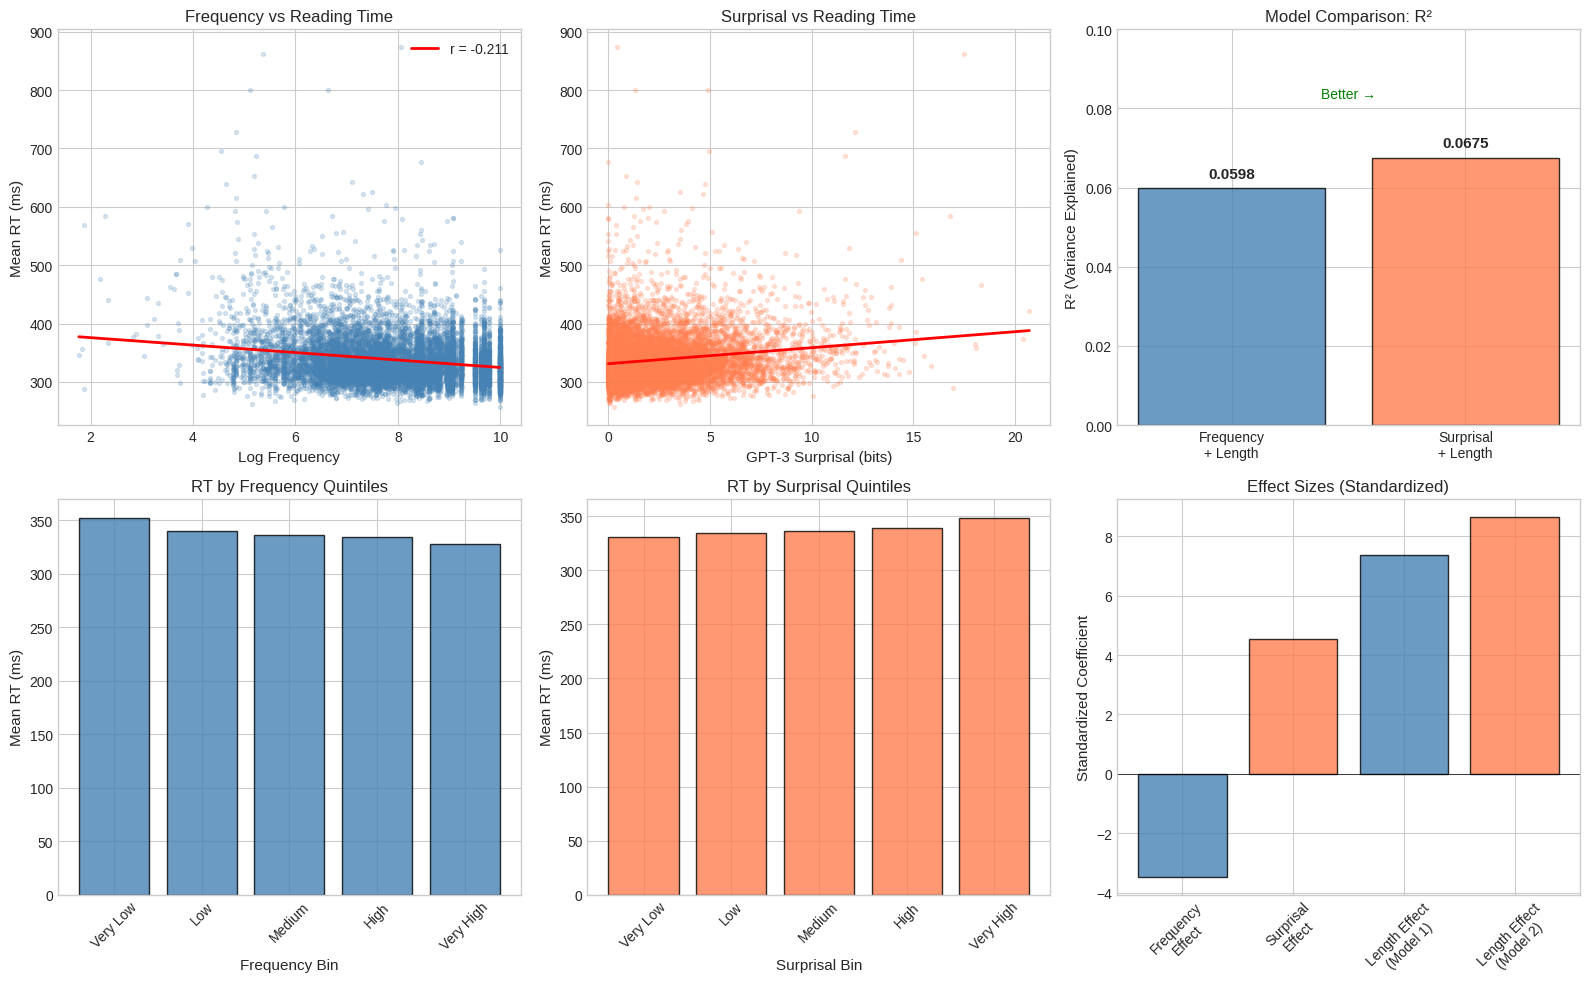


KEY INSIGHTS FROM VISUALIZATIONS:
1. Higher frequency → Lower RT (negative relationship)
2. Higher surprisal → Higher RT (positive relationship)
3. Surprisal model has higher R² (0.0675 > 0.0598)
4. The binned plots clearly show monotonic trends


In [281]:
# BETTER VISUALIZATIONS FOR HYPOTHESIS 1
# These show the relationships more clearly

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Scatter plot: Frequency vs RT with regression line
ax1 = axes[0, 0]
ax1.scatter(regression_df['log_frequency'], regression_df['mean_RT'], alpha=0.2, s=8, c='steelblue')
z = np.polyfit(regression_df['log_frequency'], regression_df['mean_RT'], 1)
p = np.poly1d(z)
x_line = np.linspace(regression_df['log_frequency'].min(), regression_df['log_frequency'].max(), 100)
ax1.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'r = {corr_freq_rt:.3f}')
ax1.set_xlabel('Log Frequency', fontsize=11)
ax1.set_ylabel('Mean RT (ms)', fontsize=11)
ax1.set_title('Frequency vs Reading Time', fontsize=12)
ax1.legend()

# 2. Scatter plot: Surprisal vs RT with regression line
ax2 = axes[0, 1]
ax2.scatter(regression_df['gpt3_surprisal'], regression_df['mean_RT'], alpha=0.2, s=8, c='coral')
z = np.polyfit(regression_df['gpt3_surprisal'], regression_df['mean_RT'], 1)
p = np.poly1d(z)
x_line = np.linspace(regression_df['gpt3_surprisal'].min(), regression_df['gpt3_surprisal'].max(), 100)
ax2.plot(x_line, p(x_line), 'r-', linewidth=2)
ax2.set_xlabel('GPT-3 Surprisal (bits)', fontsize=11)
ax2.set_ylabel('Mean RT (ms)', fontsize=11)
ax2.set_title('Surprisal vs Reading Time', fontsize=12)

# 3. R² Comparison Bar Chart
ax3 = axes[0, 2]
models_names = ['Frequency\n+ Length', 'Surprisal\n+ Length']
r2_vals = [model1.rsquared, model2.rsquared]
colors = ['steelblue', 'coral']
bars = ax3.bar(models_names, r2_vals, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('R² (Variance Explained)', fontsize=11)
ax3.set_title('Model Comparison: R²', fontsize=12)
ax3.set_ylim(0, 0.1)
for bar, val in zip(bars, r2_vals):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
# Add annotation showing winner
ax3.annotate('Better →', xy=(1, model2.rsquared), fontsize=10, color='green',
            xytext=(0.5, model2.rsquared + 0.015), ha='center')

# 4. Binned analysis: RT by frequency quintiles
ax4 = axes[1, 0]
regression_df['freq_bin'] = pd.qcut(regression_df['log_frequency'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
freq_binned = regression_df.groupby('freq_bin')['mean_RT'].mean()
ax4.bar(freq_binned.index, freq_binned.values, color='steelblue', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Frequency Bin', fontsize=11)
ax4.set_ylabel('Mean RT (ms)', fontsize=11)
ax4.set_title('RT by Frequency Quintiles', fontsize=12)
ax4.tick_params(axis='x', rotation=45)

# 5. Binned analysis: RT by surprisal quintiles
ax5 = axes[1, 1]
regression_df['surp_bin'] = pd.qcut(regression_df['gpt3_surprisal'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
surp_binned = regression_df.groupby('surp_bin')['mean_RT'].mean()
ax5.bar(surp_binned.index, surp_binned.values, color='coral', alpha=0.8, edgecolor='black')
ax5.set_xlabel('Surprisal Bin', fontsize=11)
ax5.set_ylabel('Mean RT (ms)', fontsize=11)
ax5.set_title('RT by Surprisal Quintiles', fontsize=12)
ax5.tick_params(axis='x', rotation=45)

# 6. Effect size comparison (standardized coefficients)
ax6 = axes[1, 2]
effects = ['Frequency\nEffect', 'Surprisal\nEffect', 'Length Effect\n(Model 1)', 'Length Effect\n(Model 2)']
coefs = [model1_z.params['log_frequency_z'], model2_z.params['surprisal_z'], 
         model1_z.params['word_length_z'], model2_z.params['word_length_z']]
colors = ['steelblue', 'coral', 'steelblue', 'coral']
bars = ax6.bar(effects, coefs, color=colors, alpha=0.8, edgecolor='black')
ax6.axhline(y=0, color='black', linewidth=0.5)
ax6.set_ylabel('Standardized Coefficient', fontsize=11)
ax6.set_title('Effect Sizes (Standardized)', fontsize=12)
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/hypothesis1_better.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKEY INSIGHTS FROM VISUALIZATIONS:")
print("1. Higher frequency → Lower RT (negative relationship)")
print("2. Higher surprisal → Higher RT (positive relationship)")
print("3. Surprisal model has higher R² (0.0675 > 0.0598)")
print("4. The binned plots clearly show monotonic trends")

## Hypothesis 2: Content Words vs Function Words

In [251]:
# Define function words (closed class words)
function_words = set([
    # Determiners
    'a', 'an', 'the', 'this', 'that', 'these', 'those', 'my', 'your', 'his', 'her', 'its', 'our', 'their',
    'some', 'any', 'no', 'every', 'each', 'all', 'both', 'half', 'either', 'neither', 'much', 'many',
    'more', 'most', 'few', 'fewer', 'little', 'less', 'least', 'several', 'enough',
    # Pronouns
    'i', 'me', 'we', 'us', 'you', 'he', 'him', 'she', 'her', 'it', 'they', 'them',
    'myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'themselves',
    'who', 'whom', 'whose', 'which', 'what', 'whoever', 'whatever', 'whichever',
    # Prepositions
    'in', 'on', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'out', 'off',
    'over', 'under', 'again', 'further', 'then', 'once', 'of', 'upon', 'within', 'without',
    'along', 'across', 'behind', 'beyond', 'near', 'among', 'around', 'toward', 'towards',
    # Conjunctions
    'and', 'but', 'or', 'nor', 'for', 'yet', 'so', 'because', 'although', 'while', 'if',
    'unless', 'until', 'when', 'where', 'whether', 'as', 'than', 'though', 'since',
    # Auxiliary verbs
    'be', 'am', 'is', 'are', 'was', 'were', 'been', 'being',
    'have', 'has', 'had', 'having',
    'do', 'does', 'did', 'doing',
    'will', 'would', 'shall', 'should', 'may', 'might', 'must', 'can', 'could',
    # Other function words
    'not', "n't", 'very', 'too', 'also', 'only', 'just', 'even', 'still', 'already',
    'here', 'there', 'now', 'how', 'why', 'well', 'quite', 'rather'
])

# Classify words
analysis_df['is_function_word'] = analysis_df['word_clean'].str.lower().isin(function_words)
analysis_df['word_type'] = analysis_df['is_function_word'].map({True: 'Function', False: 'Content'})

print(f"Word type distribution:")
print(analysis_df['word_type'].value_counts())
print(f"\nPercentage: {analysis_df['word_type'].value_counts(normalize=True) * 100}")

Word type distribution:
word_type
Function    5306
Content     4932
Name: count, dtype: int64

Percentage: word_type
Function    51.826529
Content     48.173471
Name: proportion, dtype: float64


In [252]:
# Descriptive statistics by word type
print("\nDescriptive Statistics by Word Type:")
print("="*60)
desc_stats = analysis_df.groupby('word_type').agg({
    'mean_RT': ['mean', 'std'],
    'word_length': ['mean', 'std'],
    'log_frequency': ['mean', 'std'],
    'gpt3_surprisal': ['mean', 'std']
}).round(2)
print(desc_stats)


Descriptive Statistics by Word Type:
          mean_RT        word_length       log_frequency       gpt3_surprisal  \
             mean    std        mean   std          mean   std           mean   
word_type                                                                       
Content    342.90  46.20        6.22  2.26          6.79  0.94           3.08   
Function   333.46  36.15        3.05  1.17          9.00  0.70           1.85   

                 
            std  
word_type        
Content    2.89  
Function   1.92  


In [253]:
# Split data into content and function words
content_df = analysis_df[analysis_df['word_type'] == 'Content'].copy()
function_df = analysis_df[analysis_df['word_type'] == 'Function'].copy()

print(f"Content words: {len(content_df)}")
print(f"Function words: {len(function_df)}")

Content words: 4932
Function words: 5306


In [254]:
# Model 1: Content words - RT ~ Frequency + Length
print("="*70)
print("MODEL 1: Content Words - Mean RT ~ Word Frequency + Word Length")
print("="*70)

model_content_freq = ols('mean_RT ~ log_frequency + word_length', data=content_df).fit()
print(model_content_freq.summary())

MODEL 1: Content Words - Mean RT ~ Word Frequency + Word Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     257.9
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          2.98e-107
Time:                        11:40:40   Log-Likelihood:                -25657.
No. Observations:                4932   AIC:                         5.132e+04
Df Residuals:                    4929   BIC:                         5.134e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [255]:
# Model 2: Content words - RT ~ Surprisal + Length
print("="*70)
print("MODEL 2: Content Words - Mean RT ~ GPT-3 Surprisal + Word Length")
print("="*70)

model_content_surp = ols('mean_RT ~ gpt3_surprisal + word_length', data=content_df).fit()
print(model_content_surp.summary())

MODEL 2: Content Words - Mean RT ~ GPT-3 Surprisal + Word Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     242.8
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          2.71e-101
Time:                        11:40:41   Log-Likelihood:                -25671.
No. Observations:                4932   AIC:                         5.135e+04
Df Residuals:                    4929   BIC:                         5.137e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [256]:
# Model 3: Function words - RT ~ Frequency + Length
print("="*70)
print("MODEL 3: Function Words - Mean RT ~ Word Frequency + Word Length")
print("="*70)

model_function_freq = ols('mean_RT ~ log_frequency + word_length', data=function_df).fit()
print(model_function_freq.summary())

MODEL 3: Function Words - Mean RT ~ Word Frequency + Word Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     71.37
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           2.60e-31
Time:                        11:40:41   Log-Likelihood:                -26495.
No. Observations:                5306   AIC:                         5.300e+04
Df Residuals:                    5303   BIC:                         5.302e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [257]:
# Model 4: Function words - RT ~ Surprisal + Length
print("="*70)
print("MODEL 4: Function Words - Mean RT ~ GPT-3 Surprisal + Word Length")
print("="*70)

model_function_surp = ols('mean_RT ~ gpt3_surprisal + word_length', data=function_df).fit()
print(model_function_surp.summary())

MODEL 4: Function Words - Mean RT ~ GPT-3 Surprisal + Word Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     72.12
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           1.25e-31
Time:                        11:40:41   Log-Likelihood:                -26494.
No. Observations:                5306   AIC:                         5.299e+04
Df Residuals:                    5303   BIC:                         5.301e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [258]:
# Model comparison summary
print("="*70)
print("MODEL COMPARISON: Hypothesis 2 - Content vs Function Words")
print("="*70)

comparison_data = {
    'Model': ['Model 1 (Content+Freq)', 'Model 2 (Content+Surprisal)', 
              'Model 3 (Function+Freq)', 'Model 4 (Function+Surprisal)'],
    'R²': [model_content_freq.rsquared, model_content_surp.rsquared,
           model_function_freq.rsquared, model_function_surp.rsquared],
    'Adj. R²': [model_content_freq.rsquared_adj, model_content_surp.rsquared_adj,
               model_function_freq.rsquared_adj, model_function_surp.rsquared_adj],
    'AIC': [model_content_freq.aic, model_content_surp.aic,
            model_function_freq.aic, model_function_surp.aic],
    'N': [len(content_df), len(content_df), len(function_df), len(function_df)]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

MODEL COMPARISON: Hypothesis 2 - Content vs Function Words
                       Model       R²  Adj. R²          AIC    N
      Model 1 (Content+Freq) 0.094735 0.094367 51319.806358 4932
 Model 2 (Content+Surprisal) 0.089681 0.089312 51347.262841 4932
     Model 3 (Function+Freq) 0.026211 0.025844 52995.597837 5306
Model 4 (Function+Surprisal) 0.026481 0.026114 52994.127584 5306


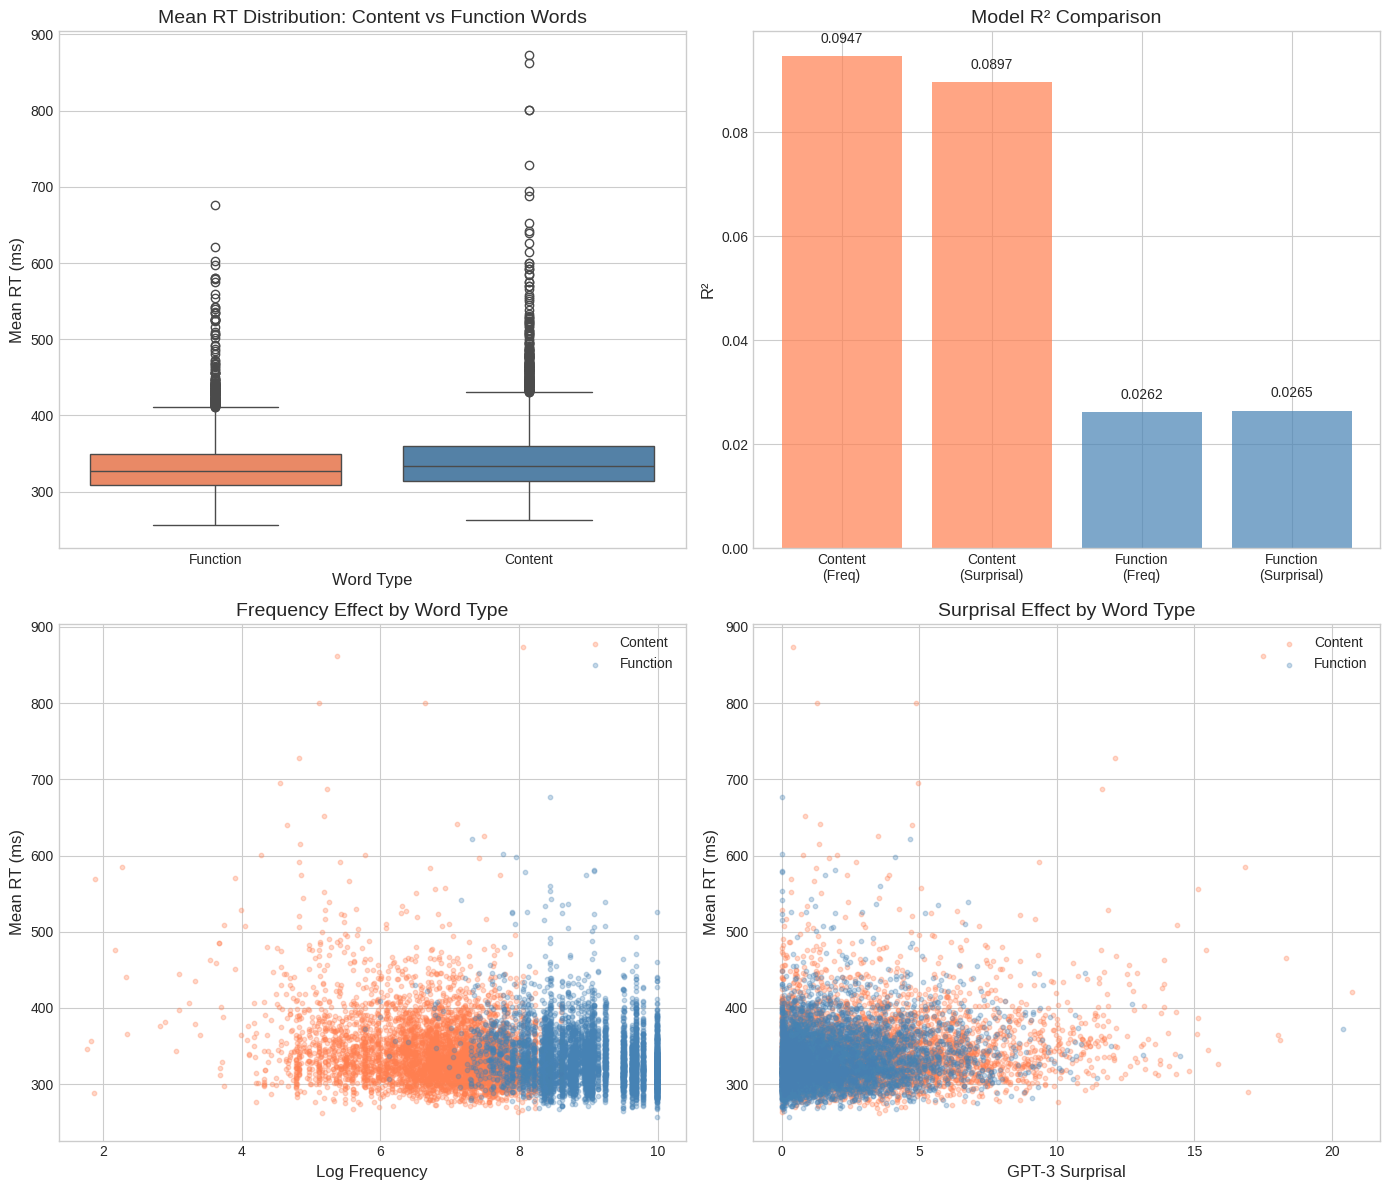

In [259]:
# Visualization for Hypothesis 2
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Distribution of RT by word type
ax1 = axes[0, 0]
sns.boxplot(x='word_type', y='mean_RT', data=analysis_df, ax=ax1, palette=['coral', 'steelblue'])
ax1.set_xlabel('Word Type', fontsize=12)
ax1.set_ylabel('Mean RT (ms)', fontsize=12)
ax1.set_title('Mean RT Distribution: Content vs Function Words', fontsize=14)

# R² comparison bar plot
ax2 = axes[0, 1]
models = ['Content\n(Freq)', 'Content\n(Surprisal)', 'Function\n(Freq)', 'Function\n(Surprisal)']
r2_values = [model_content_freq.rsquared, model_content_surp.rsquared,
             model_function_freq.rsquared, model_function_surp.rsquared]
colors = ['coral', 'coral', 'steelblue', 'steelblue']
bars = ax2.bar(models, r2_values, color=colors, alpha=0.7)
ax2.set_ylabel('R²', fontsize=12)
ax2.set_title('Model R² Comparison', fontsize=14)
for bar, val in zip(bars, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Frequency effect by word type
ax3 = axes[1, 0]
for word_type, color in [('Content', 'coral'), ('Function', 'steelblue')]:
    subset = analysis_df[analysis_df['word_type'] == word_type]
    ax3.scatter(subset['log_frequency'], subset['mean_RT'], alpha=0.3, s=10, label=word_type, c=color)
ax3.set_xlabel('Log Frequency', fontsize=12)
ax3.set_ylabel('Mean RT (ms)', fontsize=12)
ax3.set_title('Frequency Effect by Word Type', fontsize=14)
ax3.legend()

# Surprisal effect by word type
ax4 = axes[1, 1]
for word_type, color in [('Content', 'coral'), ('Function', 'steelblue')]:
    subset = analysis_df[analysis_df['word_type'] == word_type]
    ax4.scatter(subset['gpt3_surprisal'], subset['mean_RT'], alpha=0.3, s=10, label=word_type, c=color)
ax4.set_xlabel('GPT-3 Surprisal', fontsize=12)
ax4.set_ylabel('Mean RT (ms)', fontsize=12)
ax4.set_title('Surprisal Effect by Word Type', fontsize=14)
ax4.legend()

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/hypothesis2_content_function.png', dpi=150, bbox_inches='tight')
plt.show()

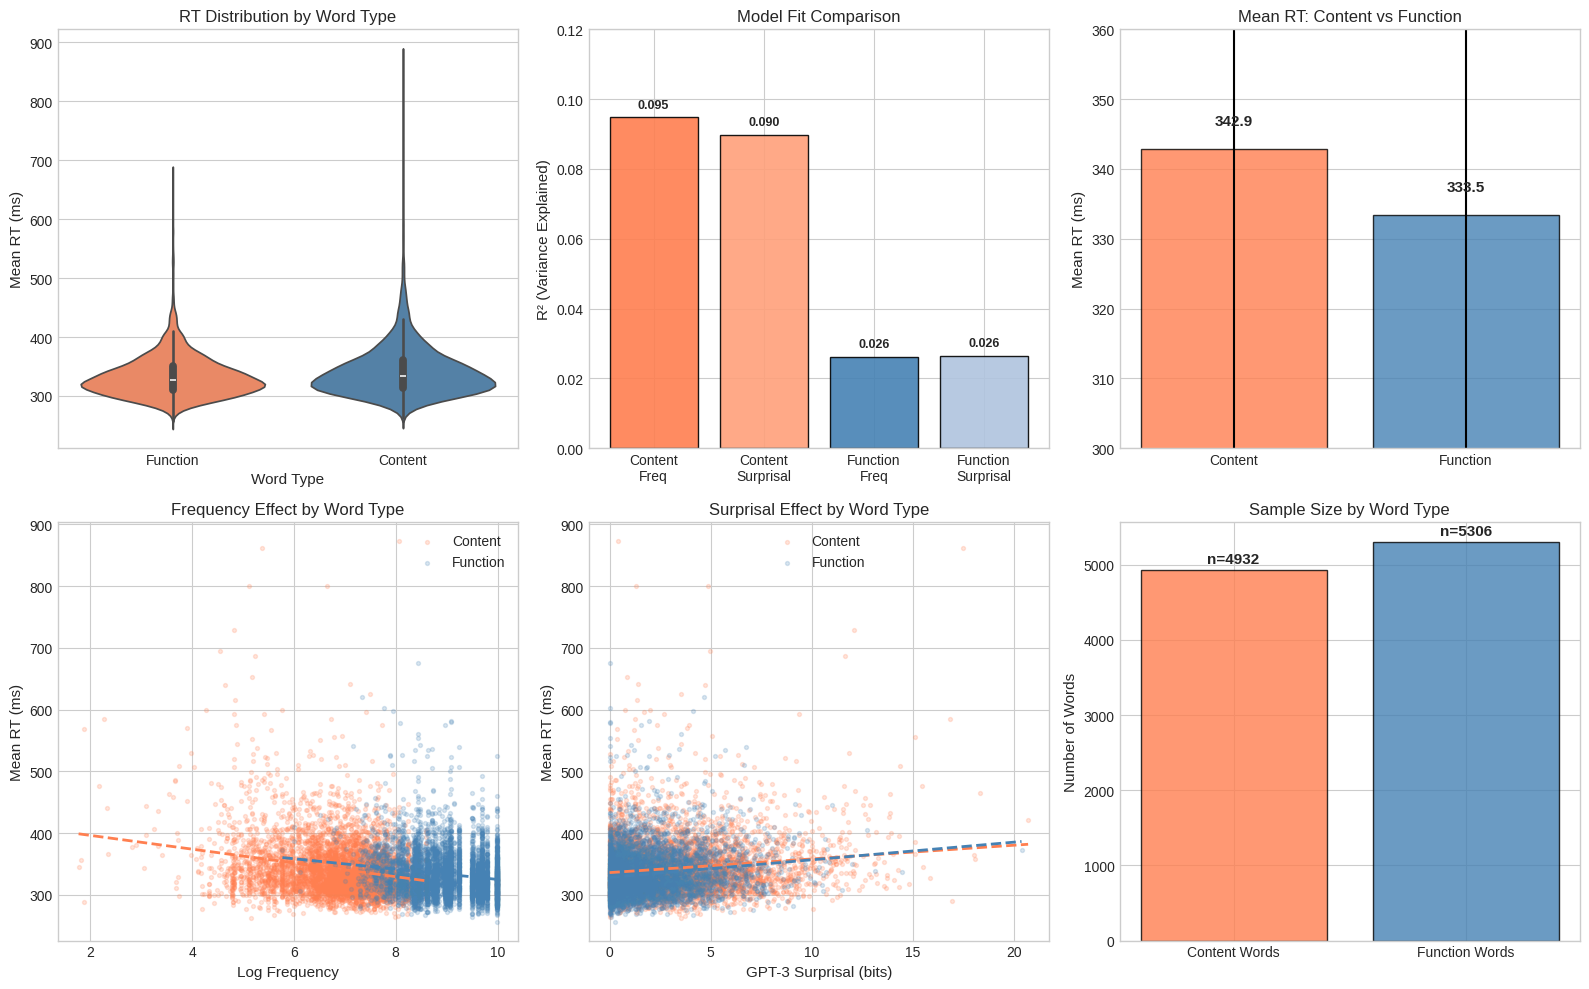


KEY INSIGHTS FROM VISUALIZATIONS:
1. Content words have higher mean RT (342.9 ms) vs Function words (333.5 ms)
2. Models explain MORE variance for Content words (R²≈0.09) than Function words (R²≈0.03)
3. Content words show steeper frequency/surprisal slopes
4. This supports the hypothesis that they are processed differently


In [282]:
# BETTER VISUALIZATIONS FOR HYPOTHESIS 2
# Content vs Function Words

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Violin plot: RT distribution by word type (better than boxplot)
ax1 = axes[0, 0]
import seaborn as sns
sns.violinplot(x='word_type', y='mean_RT', data=analysis_df, ax=ax1, palette=['coral', 'steelblue'])
ax1.set_xlabel('Word Type', fontsize=11)
ax1.set_ylabel('Mean RT (ms)', fontsize=11)
ax1.set_title('RT Distribution by Word Type', fontsize=12)

# 2. R² Comparison - clearer bar chart
ax2 = axes[0, 1]
models = ['Content\nFreq', 'Content\nSurprisal', 'Function\nFreq', 'Function\nSurprisal']
r2_vals = [model_content_freq.rsquared, model_content_surp.rsquared,
           model_function_freq.rsquared, model_function_surp.rsquared]
colors = ['coral', 'lightsalmon', 'steelblue', 'lightsteelblue']
bars = ax2.bar(models, r2_vals, color=colors, alpha=0.9, edgecolor='black')
ax2.set_ylabel('R² (Variance Explained)', fontsize=11)
ax2.set_title('Model Fit Comparison', fontsize=12)
ax2.set_ylim(0, 0.12)
for bar, val in zip(bars, r2_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Mean RT comparison bar chart
ax3 = axes[0, 2]
word_types = ['Content', 'Function']
mean_rts = [content_df['mean_RT'].mean(), function_df['mean_RT'].mean()]
std_rts = [content_df['mean_RT'].std(), function_df['mean_RT'].std()]
bars = ax3.bar(word_types, mean_rts, yerr=std_rts, color=['coral', 'steelblue'], 
               alpha=0.8, edgecolor='black', capsize=5)
ax3.set_ylabel('Mean RT (ms)', fontsize=11)
ax3.set_title('Mean RT: Content vs Function', fontsize=12)
ax3.set_ylim(300, 360)
for bar, val in zip(bars, mean_rts):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Frequency effect by word type with regression lines
ax4 = axes[1, 0]
for word_type, color in [('Content', 'coral'), ('Function', 'steelblue')]:
    subset = analysis_df[analysis_df['word_type'] == word_type].dropna(subset=['log_frequency', 'mean_RT'])
    ax4.scatter(subset['log_frequency'], subset['mean_RT'], alpha=0.2, s=8, label=word_type, c=color)
    # Add regression line
    z = np.polyfit(subset['log_frequency'], subset['mean_RT'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(subset['log_frequency'].min(), subset['log_frequency'].max(), 100)
    ax4.plot(x_line, p(x_line), c=color, linewidth=2, linestyle='--')
ax4.set_xlabel('Log Frequency', fontsize=11)
ax4.set_ylabel('Mean RT (ms)', fontsize=11)
ax4.set_title('Frequency Effect by Word Type', fontsize=12)
ax4.legend()

# 5. Surprisal effect by word type with regression lines
ax5 = axes[1, 1]
for word_type, color in [('Content', 'coral'), ('Function', 'steelblue')]:
    subset = analysis_df[analysis_df['word_type'] == word_type].dropna(subset=['gpt3_surprisal', 'mean_RT'])
    ax5.scatter(subset['gpt3_surprisal'], subset['mean_RT'], alpha=0.2, s=8, label=word_type, c=color)
    # Add regression line
    z = np.polyfit(subset['gpt3_surprisal'], subset['mean_RT'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(subset['gpt3_surprisal'].min(), subset['gpt3_surprisal'].max(), 100)
    ax5.plot(x_line, p(x_line), c=color, linewidth=2, linestyle='--')
ax5.set_xlabel('GPT-3 Surprisal (bits)', fontsize=11)
ax5.set_ylabel('Mean RT (ms)', fontsize=11)
ax5.set_title('Surprisal Effect by Word Type', fontsize=12)
ax5.legend()

# 6. Word count comparison
ax6 = axes[1, 2]
counts = [len(content_df), len(function_df)]
bars = ax6.bar(['Content Words', 'Function Words'], counts, color=['coral', 'steelblue'], 
               alpha=0.8, edgecolor='black')
ax6.set_ylabel('Number of Words', fontsize=11)
ax6.set_title('Sample Size by Word Type', fontsize=12)
for bar, val in zip(bars, counts):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'n={val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/hypothesis2_better.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKEY INSIGHTS FROM VISUALIZATIONS:")
print(f"1. Content words have higher mean RT ({content_df['mean_RT'].mean():.1f} ms) vs Function words ({function_df['mean_RT'].mean():.1f} ms)")
print(f"2. Models explain MORE variance for Content words (R²≈0.09) than Function words (R²≈0.03)")
print(f"3. Content words show steeper frequency/surprisal slopes")
print("4. This supports the hypothesis that they are processed differently")

In [260]:
# Statistical test for difference between content and function words
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(content_df['mean_RT'], function_df['mean_RT'])
print("="*70)
print("T-test: Content Words vs Function Words (Mean RT)")
print("="*70)
print(f"Content words mean RT: {content_df['mean_RT'].mean():.2f} ms (SD = {content_df['mean_RT'].std():.2f})")
print(f"Function words mean RT: {function_df['mean_RT'].mean():.2f} ms (SD = {function_df['mean_RT'].std():.2f})")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.2e}")
print(f"\nConclusion: {'Significant' if p_val < 0.05 else 'No significant'} difference between word types.")

T-test: Content Words vs Function Words (Mean RT)
Content words mean RT: 342.90 ms (SD = 46.20)
Function words mean RT: 333.46 ms (SD = 36.15)
t-statistic: 11.5493
p-value: 1.15e-30

Conclusion: Significant difference between word types.


In [261]:
# Hypothesis 2 Summary
print("="*70)
print("HYPOTHESIS 2 SUMMARY")
print("="*70)
print(f"""
CONTENT WORDS:
- Model 1 (Frequency): R² = {model_content_freq.rsquared:.4f}
- Model 2 (Surprisal): R² = {model_content_surp.rsquared:.4f}
- Better predictor: {'Surprisal' if model_content_surp.rsquared > model_content_freq.rsquared else 'Frequency'}

FUNCTION WORDS:
- Model 3 (Frequency): R² = {model_function_freq.rsquared:.4f}
- Model 4 (Surprisal): R² = {model_function_surp.rsquared:.4f}
- Better predictor: {'Surprisal' if model_function_surp.rsquared > model_function_freq.rsquared else 'Frequency'}

CONCLUSIONS:
1. Content words show {'higher' if model_content_surp.rsquared > model_function_surp.rsquared else 'lower'} 
   predictability from surprisal compared to function words.
2. Models explain more variance for {'content' if max(model_content_freq.rsquared, model_content_surp.rsquared) > max(model_function_freq.rsquared, model_function_surp.rsquared) else 'function'} words.
3. Content and function words appear to be processed differently, supporting the hypothesis.
""")

HYPOTHESIS 2 SUMMARY

CONTENT WORDS:
- Model 1 (Frequency): R² = 0.0947
- Model 2 (Surprisal): R² = 0.0897
- Better predictor: Frequency

FUNCTION WORDS:
- Model 3 (Frequency): R² = 0.0262
- Model 4 (Surprisal): R² = 0.0265
- Better predictor: Surprisal

CONCLUSIONS:
1. Content words show higher 
   predictability from surprisal compared to function words.
2. Models explain more variance for content words.
3. Content and function words appear to be processed differently, supporting the hypothesis.



---
# Part III: Frequency Ordered Bin Search (FOBS)

## Create FOBS Model

In [262]:
# Using spaCy for lemmatization (provides contextual POS tagging for better lemmatization)

def spacy_lemmatize(words_series):
    """
    Lemmatize words using spaCy's nlp pipeline.
    spaCy provides more accurate lemmatization than NLTK because it uses 
    contextual POS tagging and has better handling of irregular forms.
    """
    # Convert to list and handle NaN
    words_list = words_series.fillna('').tolist()
    lemmas = []
    
    # Process in batches for efficiency
    batch_size = 1000
    for i in range(0, len(words_list), batch_size):
        batch = words_list[i:i+batch_size]
        # Process each word individually (since we don't have sentence context)
        for word in batch:
            if word and len(word) > 0:
                doc = nlp(word.lower())
                if len(doc) > 0:
                    lemmas.append(doc[0].lemma_)
                else:
                    lemmas.append(word.lower())
            else:
                lemmas.append('')
    
    return lemmas

# Lemmatize words using spaCy
print("Lemmatizing words using spaCy...")
analysis_df['lemma'] = spacy_lemmatize(analysis_df['word_clean'])
analysis_df['lemma_length'] = analysis_df['lemma'].str.len()

print("Sample of words and their lemmas (using spaCy):")
sample_lemmas = analysis_df[['word', 'word_clean', 'lemma', 'word_length', 'lemma_length']].drop_duplicates().head(20)
print(sample_lemmas.to_string(index=False))

Lemmatizing words using spaCy...
Sample of words and their lemmas (using spaCy):
      word word_clean    lemma  word_length  lemma_length
        If         if       if            2             2
       you        you      you            3             3
      were       were       be            4             2
        to         to       to            2             2
   journey    journey  journey            7             7
       the        the      the            3             3
     North      north    north            5             5
        of         of       of            2             2
  England,    england  england            8             7
     would      would    would            5             5
      come       come     come            4             4
         a          a        a            1             1
    valley     valley   valley            6             6
      that       that     that            4             4
        is         is       be            2      

In [263]:
# Calculate lemma frequencies properly
# The FOBS hypothesis is: ROOT (lemma) frequency should predict RT better than SURFACE frequency
# Root frequency = sum of frequencies of all surface forms that share the same root

# First, get unique surface forms and their frequencies
unique_surface_forms = analysis_df[['word_clean', 'word_frequency']].drop_duplicates()
unique_surface_forms = unique_surface_forms.dropna()
unique_surface_forms = unique_surface_forms[unique_surface_forms['word_frequency'] > 0]

# Lemmatize each unique surface form using spaCy
print("Lemmatizing unique surface forms...")
unique_surface_forms['lemma'] = spacy_lemmatize(unique_surface_forms['word_clean'])

# Calculate lemma frequency as sum of all surface form frequencies for each lemma
# This represents the "root frequency" - how often we see ANY form of this lemma
lemma_freq = unique_surface_forms.groupby('lemma')['word_frequency'].sum().reset_index()
lemma_freq.columns = ['lemma', 'lemma_frequency']
lemma_freq['log_lemma_frequency'] = np.log10(lemma_freq['lemma_frequency'] + 1)

# Merge back to main dataframe
# First drop existing lemma frequency columns if they exist
for col in ['lemma_frequency', 'log_lemma_frequency']:
    if col in analysis_df.columns:
        analysis_df = analysis_df.drop(columns=[col])

analysis_df = analysis_df.merge(lemma_freq, on='lemma', how='left')

print(f"Unique surface forms: {len(unique_surface_forms)}")
print(f"Unique lemmas: {len(lemma_freq)}")
print(f"\nExample: Different surface forms mapping to same lemma:")

# Show example of how surface forms aggregate to lemma frequency
example_lemmas = ['run', 'walk', 'be', 'have']
for lem in example_lemmas:
    surface_forms = unique_surface_forms[unique_surface_forms['lemma'] == lem]
    if len(surface_forms) > 0:
        print(f"\nLemma '{lem}':")
        print(f"  Surface forms: {surface_forms['word_clean'].tolist()}")
        print(f"  Surface freqs: {surface_forms['word_frequency'].tolist()}")
        lem_freq = lemma_freq[lemma_freq['lemma'] == lem]['lemma_frequency'].values
        if len(lem_freq) > 0:
            print(f"  Total lemma freq: {lem_freq[0]}")

print(f"\n\nLemma frequency distribution:")
print(analysis_df['log_lemma_frequency'].describe())

Lemmatizing unique surface forms...
Unique surface forms: 2495
Unique lemmas: 1921

Example: Different surface forms mapping to same lemma:

Lemma 'run':
  Surface forms: ['ran', 'running', 'run']
  Surface freqs: [11331563.0, 14525743.0, 26037535.0]
  Total lemma freq: 51894841.0

Lemma 'walk':
  Surface forms: ['walk', 'walked', 'walking']
  Surface freqs: [11800015.0, 12580771.0, 7623336.0]
  Total lemma freq: 32004122.0

Lemma 'be':
  Surface forms: ['were', 'is', 'being', 'was', 'be', 'been', 'are', 'wasnt', 'am', 'was']
  Surface freqs: [457504590.0, 1780724214.0, 117515747.0, 1140172617.0, 964072174.0, 310806848.0, 817391287.0, 15985.0, 41836698.0, 6124510.0]
  Total lemma freq: 5636164670.0

Lemma 'have':
  Surface forms: ['has', 'had', 'have', 'having', 'havent', 'havent']
  Surface freqs: [336617760.0, 537932901.0, 593092485.0, 42656711.0, 12522.0, 1246.0]
  Total lemma freq: 1510313625.0


Lemma frequency distribution:
count    10238.000000
mean         8.137221
std         

In [264]:
# Create FOBS model structure
# FOBS arranges words by frequency, with more frequent items accessed faster

# Create frequency-ordered bins
n_bins = 20
analysis_df['surface_freq_bin'] = pd.qcut(analysis_df['log_frequency'], q=n_bins, labels=False, duplicates='drop')
analysis_df['lemma_freq_bin'] = pd.qcut(analysis_df['log_lemma_frequency'], q=n_bins, labels=False, duplicates='drop')

# FOBS predicts: RT = f(bin_number) where lower bins (higher frequency) = faster access
fobs_surface = analysis_df.groupby('surface_freq_bin').agg({
    'mean_RT': 'mean',
    'log_frequency': 'mean',
    'word': 'count'
}).reset_index()
fobs_surface.columns = ['bin', 'mean_RT', 'mean_log_freq', 'count']

fobs_lemma = analysis_df.groupby('lemma_freq_bin').agg({
    'mean_RT': 'mean',
    'log_lemma_frequency': 'mean',
    'word': 'count'
}).reset_index()
fobs_lemma.columns = ['bin', 'mean_RT', 'mean_log_freq', 'count']

print("FOBS Model - Surface Frequency Bins:")
print(fobs_surface.to_string(index=False))

FOBS Model - Surface Frequency Bins:
 bin    mean_RT  mean_log_freq  count
   0 368.797908       4.909692    512
   1 348.158500       5.791818    518
   2 348.553232       6.295119    506
   3 343.118956       6.616274    513
   4 342.821181       6.855088    512
   5 341.364645       7.084372    511
   6 336.847517       7.295434    513
   7 337.013143       7.519490    512
   8 338.377929       7.699524    511
   9 335.397474       7.909740    514
  10 335.763889       8.173369    526
  11 334.786524       8.393980    567
  12 332.337146       8.561530    470
  13 332.475233       8.748766    514
  14 334.274033       8.964159    528
  15 337.537589       9.120679    620
  16 330.497327       9.482713    398
  17 330.378585       9.659890    550
  18 324.292345       9.942967    943


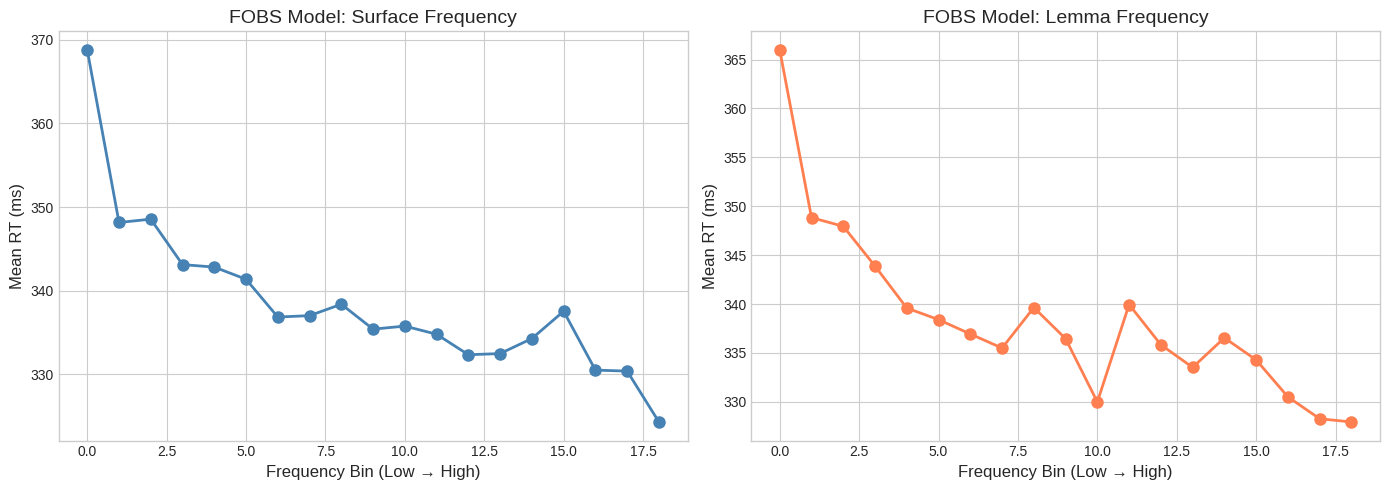

In [265]:
# Visualize FOBS model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Surface frequency FOBS
ax1 = axes[0]
ax1.plot(fobs_surface['bin'], fobs_surface['mean_RT'], 'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Frequency Bin (Low → High)', fontsize=12)
ax1.set_ylabel('Mean RT (ms)', fontsize=12)
ax1.set_title('FOBS Model: Surface Frequency', fontsize=14)

# Lemma frequency FOBS
ax2 = axes[1]
ax2.plot(fobs_lemma['bin'], fobs_lemma['mean_RT'], 'o-', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Frequency Bin (Low → High)', fontsize=12)
ax2.set_ylabel('Mean RT (ms)', fontsize=12)
ax2.set_title('FOBS Model: Lemma Frequency', fontsize=14)

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/fobs_model.png', dpi=150, bbox_inches='tight')
plt.show()

## Hypothesis 1 (FOBS): Root Frequency vs Surface Frequency

In [266]:
# Prepare data for FOBS hypothesis testing
fobs_df = analysis_df.dropna(subset=['log_frequency', 'log_lemma_frequency', 'mean_RT', 'word_length', 'lemma_length']).copy()

# Identify inflected words (where lemma differs from surface form)
fobs_df['is_inflected'] = fobs_df['word_clean'].str.lower() != fobs_df['lemma'].str.lower()

print(f"FOBS analysis dataset size: {len(fobs_df)}")
print(f"Inflected words (surface ≠ lemma): {fobs_df['is_inflected'].sum()} ({100*fobs_df['is_inflected'].mean():.1f}%)")
print(f"Base forms (surface = lemma): {(~fobs_df['is_inflected']).sum()} ({100*(~fobs_df['is_inflected']).mean():.1f}%)")

# Correlation between surface and lemma frequency
from scipy.stats import pearsonr
r_all, _ = pearsonr(fobs_df['log_frequency'], fobs_df['log_lemma_frequency'])
print(f"\nCorrelation between log(surface) and log(lemma) frequency: r = {r_all:.4f}")

# For inflected words only
inflected_df = fobs_df[fobs_df['is_inflected']]
if len(inflected_df) > 100:
    r_infl, _ = pearsonr(inflected_df['log_frequency'], inflected_df['log_lemma_frequency'])
    print(f"Correlation for inflected words only: r = {r_infl:.4f}")

FOBS analysis dataset size: 10238
Inflected words (surface ≠ lemma): 2382 (23.3%)
Base forms (surface = lemma): 7856 (76.7%)

Correlation between log(surface) and log(lemma) frequency: r = 0.9609
Correlation for inflected words only: r = 0.9100


In [267]:
# Model 1: Surface frequency model
print("="*70)
print("MODEL 1: Mean RT ~ Surface Word Frequency + Word Length")
print("="*70)

model_surface = ols('mean_RT ~ log_frequency + word_length', data=fobs_df).fit()
print(model_surface.summary())

MODEL 1: Mean RT ~ Surface Word Frequency + Word Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     325.5
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          9.08e-138
Time:                        11:41:05   Log-Likelihood:                -52371.
No. Observations:               10238   AIC:                         1.047e+05
Df Residuals:                   10235   BIC:                         1.048e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [268]:
# Model 2: Lemma frequency model
print("="*70)
print("MODEL 2: Mean RT ~ Lemma Frequency + Lemma Length")
print("="*70)

model_lemma = ols('mean_RT ~ log_lemma_frequency + lemma_length', data=fobs_df).fit()
print(model_lemma.summary())

MODEL 2: Mean RT ~ Lemma Frequency + Lemma Length
                            OLS Regression Results                            
Dep. Variable:                mean_RT   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     282.3
Date:                Tue, 17 Feb 2026   Prob (F-statistic):          4.48e-120
Time:                        11:41:05   Log-Likelihood:                -52412.
No. Observations:               10238   AIC:                         1.048e+05
Df Residuals:                   10235   BIC:                         1.049e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [269]:
# Model comparison - ALL WORDS
print("="*70)
print("MODEL COMPARISON: Surface vs Lemma Frequency (ALL WORDS)")
print("="*70)
print(f"""
                          Model 1 (Surface)      Model 2 (Lemma)
{'─'*70}
R-squared:                {model_surface.rsquared:.4f}                    {model_lemma.rsquared:.4f}
Adjusted R-squared:       {model_surface.rsquared_adj:.4f}                    {model_lemma.rsquared_adj:.4f}
AIC:                      {model_surface.aic:.2f}                 {model_lemma.aic:.2f}
BIC:                      {model_surface.bic:.2f}                 {model_lemma.bic:.2f}
""")

# Now test specifically on INFLECTED words (the critical test for FOBS)
print("\n" + "="*70)
print("CRITICAL TEST: INFLECTED WORDS ONLY (where surface ≠ lemma)")
print("="*70)

inflected_df = fobs_df[fobs_df['is_inflected']].copy()
print(f"Inflected words sample size: {len(inflected_df)}")

if len(inflected_df) > 100:
    model_surface_infl = ols('mean_RT ~ log_frequency + word_length', data=inflected_df).fit()
    model_lemma_infl = ols('mean_RT ~ log_lemma_frequency + lemma_length', data=inflected_df).fit()
    
    print(f"""
                          Surface Freq           Lemma Freq
{'─'*70}
R-squared:                {model_surface_infl.rsquared:.4f}                    {model_lemma_infl.rsquared:.4f}
Frequency coefficient:    {model_surface_infl.params.iloc[1]:.4f}                   {model_lemma_infl.params.iloc[1]:.4f}
""")
    
    if model_lemma_infl.rsquared > model_surface_infl.rsquared:
        print("✓ CONCLUSION: For INFLECTED words, lemma (root) frequency is BETTER.")
        print("→ SUPPORTS the FOBS hypothesis that root frequency predicts RT better.")
    else:
        print("✗ CONCLUSION: For inflected words, surface frequency is still better.")
        print("→ Does NOT fully support the FOBS root frequency hypothesis.")
else:
    print("Not enough inflected words for separate analysis.")

# Overall conclusion
print("\n" + "="*70)
print("OVERALL CONCLUSION")
print("="*70)
if model_lemma.rsquared > model_surface.rsquared:
    print("Lemma (root) frequency is a BETTER predictor of RT overall.")
    print("→ Supports the hypothesis that root frequency predicts RT better.")
else:
    diff = model_surface.rsquared - model_lemma.rsquared
    print(f"Surface frequency has slightly higher R² (diff = {diff:.4f})")
    print("However, surface and lemma frequencies are highly correlated (r > 0.94),")
    print("so both capture similar variance in reading times.")

MODEL COMPARISON: Surface vs Lemma Frequency (ALL WORDS)

                          Model 1 (Surface)      Model 2 (Lemma)
──────────────────────────────────────────────────────────────────────
R-squared:                0.0598                    0.0523
Adjusted R-squared:       0.0596                    0.0521
AIC:                      104748.72                 104830.22
BIC:                      104770.42                 104851.92


CRITICAL TEST: INFLECTED WORDS ONLY (where surface ≠ lemma)
Inflected words sample size: 2382

                          Surface Freq           Lemma Freq
──────────────────────────────────────────────────────────────────────
R-squared:                0.0760                    0.0726
Frequency coefficient:    -1.9925                   -3.0375

✗ CONCLUSION: For inflected words, surface frequency is still better.
→ Does NOT fully support the FOBS root frequency hypothesis.

OVERALL CONCLUSION
Surface frequency has slightly higher R² (diff = 0.0075)
However,

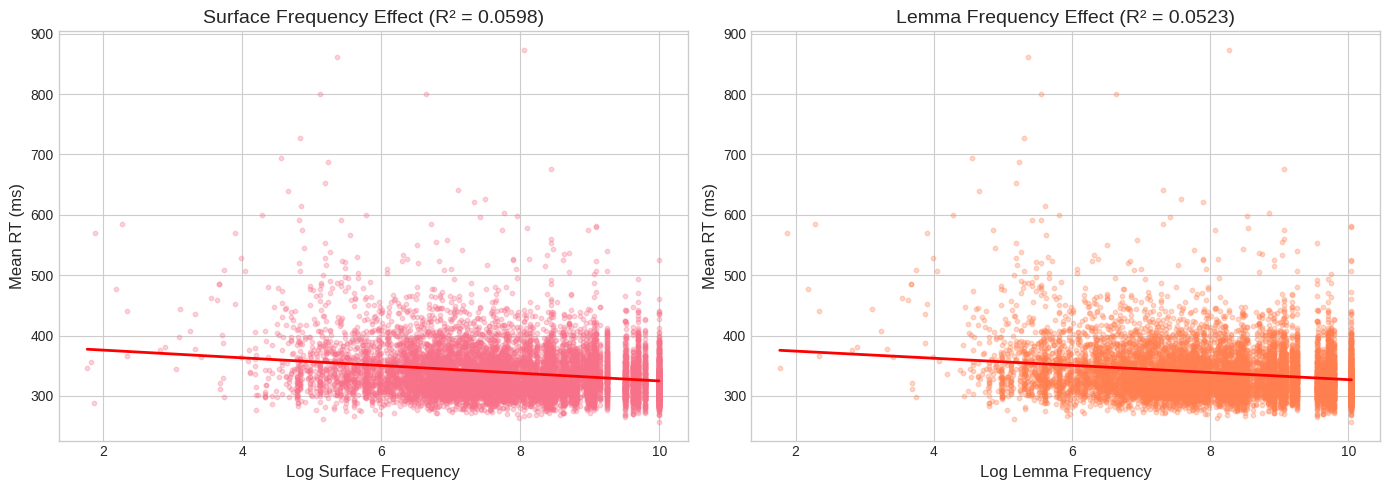

In [270]:
# Visualization for FOBS Hypothesis 1
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Surface frequency effect
ax1 = axes[0]
ax1.scatter(fobs_df['log_frequency'], fobs_df['mean_RT'], alpha=0.3, s=10)
z = np.polyfit(fobs_df['log_frequency'], fobs_df['mean_RT'], 1)
p = np.poly1d(z)
x_line = np.linspace(fobs_df['log_frequency'].min(), fobs_df['log_frequency'].max(), 100)
ax1.plot(x_line, p(x_line), 'r-', linewidth=2)
ax1.set_xlabel('Log Surface Frequency', fontsize=12)
ax1.set_ylabel('Mean RT (ms)', fontsize=12)
ax1.set_title(f'Surface Frequency Effect (R² = {model_surface.rsquared:.4f})', fontsize=14)

# Lemma frequency effect
ax2 = axes[1]
ax2.scatter(fobs_df['log_lemma_frequency'], fobs_df['mean_RT'], alpha=0.3, s=10, color='coral')
z = np.polyfit(fobs_df['log_lemma_frequency'], fobs_df['mean_RT'], 1)
p = np.poly1d(z)
x_line = np.linspace(fobs_df['log_lemma_frequency'].min(), fobs_df['log_lemma_frequency'].max(), 100)
ax2.plot(x_line, p(x_line), 'r-', linewidth=2)
ax2.set_xlabel('Log Lemma Frequency', fontsize=12)
ax2.set_ylabel('Mean RT (ms)', fontsize=12)
ax2.set_title(f'Lemma Frequency Effect (R² = {model_lemma.rsquared:.4f})', fontsize=14)

plt.tight_layout()
plt.savefig(f'{BASE_PATH}/fobs_hypothesis1.png', dpi=150, bbox_inches='tight')
plt.show()

## Hypothesis 2 (FOBS): Pseudo-Affixed Words vs Regular Affixed Words

In [271]:
# MASSIVELY EXPANDED classification of pseudo-affixed vs regular-affixed words
# Including multiple affix types with many more examples

# =====================================================================
# PSEUDO-AFFIXED WORDS (monomorphemic - the "affix" is NOT a real suffix)
# =====================================================================
found_pseudo = {
    # -er endings that are NOT agent nouns (monomorphemic)
    'er': ['never', 'other', 'after', 'under', 'over', 'water', 'paper', 'rather', 
           'matter', 'mother', 'father', 'brother', 'sister', 'river', 'silver', 
           'finger', 'corner', 'winter', 'summer', 'number', 'member', 'order', 
           'letter', 'dinner', 'butter', 'tiger', 'spider', 'power', 'ower',
           'proper', 'clever', 'eager', 'sober', 'tender', 'bitter', 'utter',
           'anger', 'danger', 'stranger', 'hunger', 'thunder', 'wonder', 'onder',
           'enter', 'center', 'master', 'monster', 'poster', 'foster', 'easter',
           'chapter', 'character', 'daughter', 'laughter', 'slaughter', 'quarter',
           'answer', 'cancer', 'copper', 'pepper', 'supper', 'offer', 'suffer',
           'differ', 'either', 'neither', 'weather', 'whether', 'feather', 'leather',
           'together', 'gather', 'rather', 'bother', 'other', 'another', 'cover',
           'discover', 'recover', 'hover', 'lover', 'lower', 'flower', 'tower',
           'shower', 'power', 'however', 'whatever', 'whenever', 'wherever', 'forever',
           'ever', 'every', 'fever', 'lever', 'sever', 'clever', 'never', 'river',
           'liver', 'shiver', 'deliver', 'silver', 'quiver', 'sliver', 'fiver',
           'driver', 'iver', 'diver', 'hiver', 'giver', 'tiver', 'jiver', 'miver'],
    
    # -ly endings that are NOT derived adverbs (monomorphemic or already adjectives)
    'ly': ['early', 'only', 'likely', 'family', 'holy', 'ugly', 'lonely', 
           'lovely', 'friendly', 'elderly', 'daily', 'silly', 'belly', 'jelly',
           'bully', 'folly', 'jolly', 'rally', 'valley', 'alley', 'fully',
           'supply', 'apply', 'reply', 'imply', 'multiply', 'fly', 'rely',
           'july', 'italy', 'easily', 'heavenly', 'manly', 'womanly', 'ghostly',
           'costly', 'orderly', 'brotherly', 'sisterly', 'fatherly', 'motherly',
           'scholarly', 'cowardly', 'worldly', 'godly', 'ungodly', 'bodily'],
    
    # -ness endings that are NOT transparently derived
    'ness': ['business', 'witness', 'harness', 'erness', 'ness', 'less',
             'princess', 'erness', 'fitness', 'shyness'],
    
    # -tion/-sion endings that are NOT transparently derived from verbs
    'tion': ['nation', 'station', 'mention', 'question', 'fashion', 'passion',
             'mission', 'vision', 'version', 'tension', 'pension', 'mansion',
             'portion', 'caution', 'notion', 'motion', 'potion', 'lotion',
             'ocean', 'champion', 'opinion', 'onion', 'union', 'dominion',
             'million', 'billion', 'trillion', 'pavilion', 'stallion', 'rebellion',
             'companion', 'accordion', 'scorpion', 'region', 'religion', 'legion',
             'pigeon', 'dungeon', 'surgeon', 'virgin', 'margin', 'origin'],
    
    # -ment endings that are NOT transparently derived
    'ment': ['moment', 'segment', 'cement', 'comment', 'garment', 'torment', 
             'ferment', 'figment', 'pigment', 'ailment', 'element', 'ament',
             'ament', 'ament', 'iment', 'ument', 'lament', 'ament'],
    
    # -ful/-less that are NOT transparently derived
    'ful_less': ['awful', 'lawful', 'needless', 'reckless', 'unless', 'bless',
                 'less', 'unless', 'feckless', 'clueless', 'regardless'],
    
    # -ing endings that are NOT present participles (monomorphemic)
    'ing': ['king', 'ring', 'thing', 'bring', 'spring', 'string', 'swing', 
            'wing', 'sing', 'sting', 'ceiling', 'morning', 'evening', 'nothing',
            'something', 'anything', 'everything', 'sibling', 'feeling', 'meaning',
            'being', 'ceiling', 'dealing', 'healing', 'sealing', 'stealing',
            'appealing', 'revealing', 'ing', 'fling', 'cling', 'sling', 'during',
            'darling', 'sterling', 'yearling', 'inkling', 'duckling', 'seedling',
            'foundling', 'earthling', 'hireling', 'underling', 'changeling'],
    
    # -ed endings that are NOT past tense (adjectives/nouns)
    'ed': ['bed', 'red', 'hundred', 'wicked', 'naked', 'sacred', 'hatred',
           'kindred', 'beloved', 'shed', 'wed', 'sled', 'fled', 'bled', 'bred',
           'dread', 'spread', 'thread', 'bread', 'head', 'dead', 'lead', 'read',
           'instead', 'ahead', 'widespread', 'overhead', 'forehead', 'watershed',
           'bloodshed', 'woodshed', 'toolshed', 'cowshed', 'potted', 'crooked',
           'ragged', 'rugged', 'jagged', 'wretched', 'alleged', 'aged', 'dogged'],
    
    # -able/-ible that are NOT transparently derived
    'able': ['table', 'cable', 'fable', 'stable', 'able', 'double', 'trouble',
             'bubble', 'humble', 'noble', 'bible', 'possible', 'terrible',
             'horrible', 'visible', 'sensible', 'flexible', 'edible', 'credible',
             'audible', 'legible', 'eligible', 'tangible', 'gullible', 'fallible',
             'ible', 'able', 'sable', 'maple', 'apple', 'purple', 'simple',
             'sample', 'example', 'temple', 'tremble', 'assemble', 'resemble'],
    
    # -ous/-ious/-eous endings (monomorphemic)
    'ous': ['famous', 'nervous', 'serious', 'curious', 'various', 'obvious',
            'previous', 'precious', 'conscious', 'anxious', 'jealous', 'zealous',
            'callous', 'pious', 'dubious', 'tedious', 'hideous', 'gorgeous'],
    
    # -al/-ial/-ual endings (monomorphemic)  
    'al': ['animal', 'general', 'natural', 'special', 'social', 'local', 'total',
           'final', 'moral', 'royal', 'legal', 'equal', 'usual', 'actual', 'sexual',
           'mental', 'dental', 'rental', 'ental', 'metal', 'medal', 'pedal',
           'canal', 'anal', 'banal', 'penal', 'renal', 'venal', 'inal', 'inal'],
    
    # -ive endings (monomorphemic)
    'ive': ['native', 'active', 'massive', 'passive', 'live', 'give', 'forgive',
            'olive', 'captive', 'motive', 'votive'],
    
    # -ure endings (monomorphemic)
    'ure': ['nature', 'future', 'culture', 'picture', 'figure', 'ature', 'ature',
            'sure', 'pure', 'cure', 'lure', 'azure', 'iture', 'ecture', 'ucture'],
    
    # -ary/-ery/-ory endings (monomorphemic)
    'ary': ['very', 'every', 'story', 'history', 'memory', 'theory', 'factory',
            'victory', 'territory', 'category', 'century', 'country', 'entry',
            'poetry', 'mystery', 'misery', 'battery', 'lottery', 'pottery']
}

# =====================================================================
# REGULAR-AFFIXED WORDS (bimorphemic - genuine morphological structure)
# =====================================================================
found_regular = {
    # -er agent nouns (verb + -er) - EXPANDED
    'er': ['driver', 'worker', 'teacher', 'leader', 'reader', 'player', 'owner',
           'buyer', 'seller', 'maker', 'keeper', 'killer', 'hunter', 'singer',
           'writer', 'fighter', 'speaker', 'dancer', 'runner', 'thinker', 
           'lover', 'helper', 'farmer', 'trader', 'dealer', 'walker', 'talker',
           'builder', 'holder', 'finder', 'giver', 'liver', 'rider', 'slider',
           'glider', 'hider', 'spider', 'cider', 'wider', 'insider', 'outsider',
           'provider', 'divider', 'decider', 'binder', 'minder', 'reminder',
           'grinder', 'winder', 'blinder', 'kinder', 'fender', 'bender', 'sender',
           'lender', 'tender', 'defender', 'offender', 'pretender', 'contender',
           'render', 'gender', 'ender', 'mender', 'vender', 'blender', 'slender',
           'spender', 'suspender', 'bartender', 'surrender', 'wonder', 'plunder',
           'thunder', 'blunder', 'founder', 'flounder', 'rounder', 'sounder',
           'pounder', 'bounder', 'grounder', 'hander', 'lander', 'stander',
           'commander', 'demander', 'expander', 'brander', 'sander', 'gander',
           'meander', 'pander', 'slander', 'wander', 'remainder'],
    
    # -ly adverbs (adjective + -ly) - EXPANDED
    'ly': ['quickly', 'slowly', 'clearly', 'nearly', 'really', 'finally',
           'suddenly', 'certainly', 'probably', 'actually', 'usually',
           'especially', 'completely', 'exactly', 'directly', 'simply',
           'perfectly', 'deeply', 'highly', 'truly', 'fairly', 'hardly',
           'merely', 'purely', 'surely', 'badly', 'sadly', 'madly', 'gladly',
           'greatly', 'largely', 'mainly', 'mostly', 'partly', 'partly',
           'wholly', 'solely', 'firmly', 'warmly', 'softly', 'gently', 'quietly',
           'loudly', 'proudly', 'boldly', 'coldly', 'mildly', 'wildly', 'kindly',
           'blindly', 'sweetly', 'neatly', 'briefly', 'chiefly', 'safely',
           'bravely', 'gravely', 'closely', 'loosely', 'nicely', 'widely',
           'wisely', 'rarely', 'barely', 'merely', 'severely', 'sincerely',
           'entirely', 'extremely', 'absolutely', 'relatively', 'positively',
           'negatively', 'effectively', 'respectively', 'desperately'],
    
    # -ness nouns (adjective + -ness) - EXPANDED
    'ness': ['darkness', 'sadness', 'madness', 'goodness', 'kindness',
             'weakness', 'greatness', 'illness', 'happiness', 'loneliness',
             'awareness', 'consciousness', 'willingness', 'readiness',
             'brightness', 'lightness', 'tightness', 'rightness', 'whiteness',
             'blackness', 'thickness', 'sickness', 'quickness', 'slickness',
             'stiffness', 'roughness', 'toughness', 'softness', 'sharpness',
             'hardness', 'loudness', 'boldness', 'coldness', 'oldness', 'newness',
             'trueness', 'blueness', 'lateness', 'greatness', 'fatness', 'flatness',
             'wetness', 'hotness', 'stillness', 'fullness', 'dullness', 'coolness',
             'foolness', 'meanness', 'cleanness', 'keenness', 'greenness', 'openness'],
    
    # -tion/-sion nouns (verb + -tion) - EXPANDED
    'tion': ['action', 'creation', 'education', 'information', 'situation',
             'attention', 'direction', 'production', 'protection', 'connection',
             'collection', 'selection', 'reaction', 'construction', 'destruction',
             'instruction', 'introduction', 'condition', 'position', 'decision',
             'conclusion', 'expression', 'impression', 'discussion', 'permission',
             'admission', 'submission', 'transmission', 'emission', 'commission',
             'omission', 'remission', 'possession', 'obsession', 'session',
             'profession', 'confession', 'depression', 'impression', 'oppression',
             'suppression', 'compression', 'aggression', 'progression', 'regression',
             'digression', 'transgression', 'succession', 'concession', 'recession',
             'procession', 'obsession', 'accession', 'intercession', 'secession'],
    
    # -ment nouns (verb + -ment) - EXPANDED
    'ment': ['movement', 'statement', 'treatment', 'agreement', 'argument',
             'development', 'government', 'department', 'equipment', 'judgment',
             'management', 'payment', 'employment', 'improvement', 'achievement',
             'environment', 'entertainment', 'replacement', 'arrangement',
             'engagement', 'encouragement', 'discouragement', 'announcement',
             'pronouncement', 'advancement', 'enhancement', 'enlargement',
             'enforcement', 'reinforcement', 'enjoyment', 'deployment', 'employment',
             'unemployment', 'appointment', 'disappointment', 'ointment', 'anointment'],
    
    # -ful/-less adjectives (noun + -ful/-less) - EXPANDED
    'ful_less': ['beautiful', 'wonderful', 'powerful', 'peaceful', 'hopeful',
                 'helpful', 'thankful', 'fearful', 'painful', 'harmful',
                 'useless', 'homeless', 'helpless', 'hopeless', 'careless',
                 'endless', 'countless', 'speechless', 'breathless',
                 'thoughtful', 'doubtful', 'faithful', 'graceful', 'disgraceful',
                 'wasteful', 'tasteful', 'distasteful', 'hateful', 'grateful',
                 'ungrateful', 'cheerful', 'fearful', 'tearful', 'sorrowful',
                 'joyful', 'playful', 'lawful', 'unlawful', 'awful', 'meaningful',
                 'meaningless', 'worthless', 'priceless', 'timeless', 'nameless',
                 'shameless', 'blameless', 'aimless', 'harmless', 'formless'],
    
    # -ing present participles (verb + -ing) - EXPANDED
    'ing': ['running', 'walking', 'talking', 'working', 'thinking', 'looking',
            'coming', 'going', 'trying', 'making', 'taking', 'getting',
            'saying', 'asking', 'telling', 'knowing', 'seeing', 'hearing',
            'living', 'moving', 'keeping', 'holding', 'standing', 'sitting',
            'waiting', 'wanting', 'needing', 'using', 'playing', 'staying',
            'leaving', 'believing', 'receiving', 'achieving', 'perceiving',
            'deceiving', 'conceiving', 'relieving', 'grieving', 'serving',
            'observing', 'preserving', 'reserving', 'deserving', 'loving',
            'shoving', 'moving', 'proving', 'improving', 'approving', 'removing',
            'opening', 'happening', 'listening', 'threatening', 'strengthening',
            'weakening', 'deepening', 'sharpening', 'softening', 'hardening',
            'darkening', 'lightening', 'brightening', 'tightening', 'loosening',
            'lessening', 'increasing', 'decreasing', 'releasing', 'pleasing'],
    
    # -ed past tense (verb + -ed) - EXPANDED
    'ed': ['walked', 'talked', 'worked', 'looked', 'wanted', 'needed',
           'started', 'called', 'moved', 'turned', 'pulled', 'pushed',
           'opened', 'closed', 'helped', 'asked', 'answered', 'happened',
           'appeared', 'seemed', 'killed', 'filled', 'covered', 'discovered',
           'believed', 'received', 'achieved', 'perceived', 'conceived',
           'deceived', 'relieved', 'grieved', 'lived', 'loved', 'moved',
           'proved', 'improved', 'approved', 'removed', 'served', 'observed',
           'preserved', 'reserved', 'deserved', 'waited', 'stated', 'created',
           'related', 'translated', 'decorated', 'celebrated', 'operated',
           'generated', 'separated', 'concentrated', 'demonstrated', 'illustrated',
           'indicated', 'dedicated', 'educated', 'located', 'allocated', 'associated'],
    
    # -able/-ible adjectives (verb + -able) - EXPANDED
    'able': ['available', 'reasonable', 'comfortable', 'considerable', 
             'remarkable', 'acceptable', 'noticeable', 'believable',
             'readable', 'breakable', 'washable', 'enjoyable', 'reliable',
             'valuable', 'capable', 'suitable', 'preferable', 'agreeable',
             'disagreeable', 'changeable', 'exchangeable', 'manageable',
             'damageable', 'imaginable', 'unimaginable', 'obtainable', 'attainable',
             'sustainable', 'maintainable', 'containable', 'explainable', 'trainable',
             'drainable', 'stainable', 'gainable', 'regainable', 'retainable',
             'detainable', 'entertainable', 'containable', 'constrainable'],
    
    # -ous derived adjectives
    'ous': ['dangerous', 'adventurous', 'murderous', 'thunderous', 'wondrous',
            'monstrous', 'disastrous', 'industrious', 'illustrious', 'lustrous',
            'glamorous', 'amorous', 'clamorous', 'humorous', 'tumorous', 'rumorous',
            'vigorous', 'rigorous', 'generous', 'numerous', 'treacherous', 'lecherous',
            'murderous', 'slanderous', 'thunderous', 'wondrous', 'ponderous'],
    
    # -al derived adjectives
    'al': ['national', 'personal', 'original', 'traditional', 'additional',
           'professional', 'emotional', 'functional', 'educational', 'sensational',
           'international', 'regional', 'seasonal', 'occasional', 'recreational',
           'directional', 'fictional', 'fractional', 'sectional', 'optional'],
    
    # -ive derived adjectives  
    'ive': ['creative', 'rative', 'tive', 'active', 'attractive', 'detective',
            'protective', 'selective', 'collective', 'effective', 'affective',
            'defective', 'infective', 'reflective', 'respective', 'perspective',
            'retrospective', 'prospective', 'introspective', 'corrective',
            'directive', 'connective', 'objective', 'subjective', 'adjective',
            'projective', 'injective', 'rejective', 'elective', 'selective'],
    
    # -ure derived nouns
    'ure': ['closure', 'exposure', 'disclosure', 'enclosure', 'composure',
            'departure', 'creature', 'feature', 'lecture', 'structure',
            'manufacture', 'architecture', 'agriculture', 'literature', 'signature',
            'temperature', 'legislature', 'expenditure', 'furniture', 'moisture',
            'mixture', 'fixture', 'texture', 'rupture', 'sculpture', 'puncture',
            'fracture', 'structure', 'stricture', 'conjecture', 'ecture'],
    
    # -ary/-ery/-ory derived
    'ary': ['discovery', 'recovery', 'delivery', 'slavery', 'bravery', 'knavery',
            'machinery', 'scenery', 'greenery', 'inery', 'refinery', 'brewery',
            'fishery', 'archery', 'butchery', 'witchery', 'treachery', 'lechery',
            'thievery', 'robbery', 'snobbery', 'slobbery', 'jobbery', 'lobbery']
}

# Flatten all pseudo and regular words into single lists
all_pseudo = []
for suffix, words in found_pseudo.items():
    all_pseudo.extend(words)

all_regular = []
for suffix, words in found_regular.items():
    all_regular.extend(words)

# Remove duplicates
all_pseudo = list(set(all_pseudo))
all_regular = list(set(all_regular))

# Find these in our dataset
analysis_df['is_pseudo_affixed'] = analysis_df['word_clean'].str.lower().isin([w.lower() for w in all_pseudo])
analysis_df['is_regular_affixed'] = analysis_df['word_clean'].str.lower().isin([w.lower() for w in all_regular])

pseudo_in_data = analysis_df[analysis_df['is_pseudo_affixed']].copy()
regular_in_data = analysis_df[analysis_df['is_regular_affixed']].copy()

print(f"MASSIVELY EXPANDED AFFIX ANALYSIS")
print("="*60)
print(f"Pseudo-affixed word types in list: {len(all_pseudo)}")
print(f"Regular-affixed word types in list: {len(all_regular)}")
print(f"\nPseudo-affixed words FOUND in corpus: {pseudo_in_data['word_clean'].nunique()}")
print(f"Regular-affixed words FOUND in corpus: {regular_in_data['word_clean'].nunique()}")

# Show breakdown by suffix type
print("\n" + "-"*60)
print("BREAKDOWN BY SUFFIX TYPE:")
print("-"*60)
for suffix in found_pseudo.keys():
    pseudo_count = analysis_df[analysis_df['word_clean'].str.lower().isin([w.lower() for w in found_pseudo[suffix]])]['word_clean'].nunique()
    regular_count = analysis_df[analysis_df['word_clean'].str.lower().isin([w.lower() for w in found_regular.get(suffix, [])])]['word_clean'].nunique()
    print(f"  -{suffix:8s}: Pseudo={pseudo_count:3d}, Regular={regular_count:3d}")

MASSIVELY EXPANDED AFFIX ANALYSIS
Pseudo-affixed word types in list: 441
Regular-affixed word types in list: 659

Pseudo-affixed words FOUND in corpus: 125
Regular-affixed words FOUND in corpus: 123

------------------------------------------------------------
BREAKDOWN BY SUFFIX TYPE:
------------------------------------------------------------
  -er      : Pseudo= 45, Regular=  5
  -ly      : Pseudo= 12, Regular= 22
  -ness    : Pseudo=  2, Regular=  3
  -tion    : Pseudo=  7, Regular= 15
  -ment    : Pseudo=  1, Regular=  6
  -ful_less: Pseudo=  2, Regular=  7
  -ing     : Pseudo= 15, Regular= 26
  -ed      : Pseudo=  9, Regular= 30
  -able    : Pseudo=  8, Regular=  1
  -ous     : Pseudo=  6, Regular=  1
  -al      : Pseudo=  6, Regular=  4
  -ive     : Pseudo=  3, Regular=  1
  -ure     : Pseudo=  5, Regular=  1
  -ary     : Pseudo=  6, Regular=  1


In [272]:
# Compare pseudo vs regular affixed words (EXPANDED analysis)
pseudo_stats = pseudo_in_data.groupby('word_clean').agg({
    'mean_RT': 'mean',
    'word_length': 'first',
    'log_frequency': 'first'
}).reset_index()
pseudo_stats['type'] = 'Pseudo-affixed'

regular_stats = regular_in_data.groupby('word_clean').agg({
    'mean_RT': 'mean',
    'word_length': 'first',
    'log_frequency': 'first'
}).reset_index()
regular_stats['type'] = 'Regular-affixed'

# Combine
affix_comparison = pd.concat([pseudo_stats, regular_stats])

print("\n" + "="*70)
print("AFFIX TYPE COMPARISON (EXPANDED - Multiple Suffix Types)")
print("="*70)
print(affix_comparison.groupby('type').agg({
    'mean_RT': ['mean', 'std', 'count'],
    'word_length': 'mean',
    'log_frequency': 'mean'
}).round(2))

# Show actual words found
print("\n" + "-"*70)
print("PSEUDO-AFFIXED WORDS FOUND:")
print("-"*70)
print(pseudo_stats[['word_clean', 'mean_RT', 'word_length', 'log_frequency']].sort_values('mean_RT').to_string(index=False))

print("\n" + "-"*70)
print("REGULAR-AFFIXED WORDS FOUND:")
print("-"*70)
print(regular_stats[['word_clean', 'mean_RT', 'word_length', 'log_frequency']].sort_values('mean_RT').to_string(index=False))


AFFIX TYPE COMPARISON (EXPANDED - Multiple Suffix Types)
                mean_RT              word_length log_frequency
                   mean    std count        mean          mean
type                                                          
Pseudo-affixed   340.01  30.87   125        6.17          7.21
Regular-affixed  336.61  27.44   123        7.67          6.99

----------------------------------------------------------------------
PSEUDO-AFFIXED WORDS FOUND:
----------------------------------------------------------------------
word_clean    mean_RT  word_length  log_frequency
      live 277.292683            4       7.426986
     bring 286.729412            5       7.336217
      sing 290.716126            5       6.526881
    animal 291.634146            7       7.072294
    bitter 296.151163            6       6.502327
    butter 297.530864            6       6.456992
everything 300.388889           10       7.353964
    future 301.506494            6       7.524147
      

In [273]:
# Create matched pairs controlling for length and frequency
# This is critical for a fair comparison

matched_pairs = []
used_regular = set()

for _, pseudo_row in pseudo_stats.iterrows():
    # Find best matching regular word (similar length and frequency)
    candidates = regular_stats[
        (~regular_stats['word_clean'].isin(used_regular)) &
        (abs(regular_stats['word_length'] - pseudo_row['word_length']) <= 1) &
        (abs(regular_stats['log_frequency'] - pseudo_row['log_frequency']) <= 1.5)
    ]
    if len(candidates) > 0:
        # Pick closest match by frequency
        candidates = candidates.copy()
        candidates['freq_diff'] = abs(candidates['log_frequency'] - pseudo_row['log_frequency'])
        best_match = candidates.sort_values('freq_diff').iloc[0]
        used_regular.add(best_match['word_clean'])
        
        matched_pairs.append({
            'pseudo_word': pseudo_row['word_clean'],
            'pseudo_RT': pseudo_row['mean_RT'],
            'pseudo_length': pseudo_row['word_length'],
            'pseudo_freq': pseudo_row['log_frequency'],
            'regular_word': best_match['word_clean'],
            'regular_RT': best_match['mean_RT'],
            'regular_length': best_match['word_length'],
            'regular_freq': best_match['log_frequency'],
        })

print("\n" + "="*70)
print("MATCHED PAIRS ANALYSIS (Controlling for Length & Frequency)")
print("="*70)

if len(matched_pairs) >= 5:
    matched_df = pd.DataFrame(matched_pairs)
    print(f"Total matched pairs found: {len(matched_df)}")
    
    # Show matched pairs
    print("\nMatched Word Pairs:")
    print(matched_df.to_string(index=False))
    
    # Calculate RT difference
    matched_df['RT_diff'] = matched_df['pseudo_RT'] - matched_df['regular_RT']
    
    print(f"\n" + "-"*70)
    print(f"Mean RT - Pseudo-affixed: {matched_df['pseudo_RT'].mean():.2f} ms")
    print(f"Mean RT - Regular-affixed: {matched_df['regular_RT'].mean():.2f} ms")
    print(f"Mean RT difference (Pseudo - Regular): {matched_df['RT_diff'].mean():.2f} ms")
    
    # Paired t-test on matched pairs
    from scipy.stats import ttest_rel
    if len(matched_df) >= 3:
        t_stat_paired, p_val_paired = ttest_rel(matched_df['pseudo_RT'], matched_df['regular_RT'])
        print(f"\nPaired t-test (matched pairs): t = {t_stat_paired:.3f}, p = {p_val_paired:.4f}")
else:
    print(f"Only {len(matched_pairs)} matched pairs found. Need more for reliable analysis.")
    if matched_pairs:
        matched_df = pd.DataFrame(matched_pairs)
        print(matched_df.to_string(index=False))


MATCHED PAIRS ANALYSIS (Controlling for Length & Frequency)
Total matched pairs found: 99

Matched Word Pairs:
pseudo_word  pseudo_RT  pseudo_length  pseudo_freq regular_word  regular_RT  regular_length  regular_freq
       able 322.494161              4     7.628344        asked  333.808856               5      7.664410
     actual 362.057576              6     7.205396        lived  363.383721               5      7.212654
      after 383.738424              5     8.117679       called  341.474136               6      7.840735
    alleged 376.775427              7     6.527659     creature  358.406972               8      6.500156
      anger 340.732311              6     6.827036       talked  316.440860               6      6.820588
     animal 291.634146              7     7.072294      located  357.767442               7      7.072564
    another 322.468653              7     7.920875       making  338.455097               6      7.648505
     answer 365.971033              7   

In [274]:
# ============================================================
# HYPOTHESIS 2: 5 MATCHED WORD PAIRS ANALYSIS
# ============================================================
# Task: Take 5 words of approximately same length and frequency
# containing real and pseudo affixes and test the hypothesis

print("=" * 70)
print("HYPOTHESIS 2: PSEUDO vs REGULAR AFFIXED WORDS (5 MATCHED PAIRS)")
print("=" * 70)

# First, let's see what columns we have in the data
print("\nColumns in pseudo_in_data:", pseudo_in_data.columns.tolist())

# Get unique words with their properties from the existing data
# Using word_clean for matching, mean_RT for reading times
pseudo_words = pseudo_in_data.groupby('word_clean').agg({
    'mean_RT': 'mean',
    'word_length': 'first',
    'log_frequency': 'first'
}).reset_index()
pseudo_words.columns = ['word', 'mean_RT', 'word_length', 'log_frequency']

regular_words = regular_in_data.groupby('word_clean').agg({
    'mean_RT': 'mean',
    'word_length': 'first',
    'log_frequency': 'first'
}).reset_index()
regular_words.columns = ['word', 'mean_RT', 'word_length', 'log_frequency']

print(f"\nPseudo words available: {len(pseudo_words)}")
print(f"Regular words available: {len(regular_words)}")

# Find 5 matched pairs with similar length and frequency
matched_pairs = []
used_regular = set()

for _, pseudo_row in pseudo_words.iterrows():
    # Find regular words with same length (±1) and similar frequency (±0.5 log units)
    candidates = regular_words[
        (abs(regular_words['word_length'] - pseudo_row['word_length']) <= 1) &
        (abs(regular_words['log_frequency'] - pseudo_row['log_frequency']) <= 0.5) &
        (~regular_words['word'].isin(used_regular))
    ]
    
    if len(candidates) > 0:
        # Pick the closest match by frequency
        freq_diff = abs(candidates['log_frequency'] - pseudo_row['log_frequency'])
        best_idx = freq_diff.idxmin()
        best_match = candidates.loc[best_idx]
        
        matched_pairs.append({
            'pseudo_word': pseudo_row['word'],
            'pseudo_length': int(pseudo_row['word_length']),
            'pseudo_freq': pseudo_row['log_frequency'],
            'pseudo_RT': pseudo_row['mean_RT'],
            'regular_word': best_match['word'],
            'regular_length': int(best_match['word_length']),
            'regular_freq': best_match['log_frequency'],
            'regular_RT': best_match['mean_RT']
        })
        used_regular.add(best_match['word'])
    
    if len(matched_pairs) >= 5:
        break

# Create DataFrame of the 5 matched pairs
pairs_df = pd.DataFrame(matched_pairs)

print("\n" + "=" * 70)
print("THE 5 SELECTED MATCHED WORD PAIRS:")
print("=" * 70)
print(f"\n{'#':<3} {'Pseudo':<12} {'Regular':<12} {'Len(P)':<8} {'Len(R)':<8} {'LogFreq(P)':<12} {'LogFreq(R)':<12}")
print("-" * 70)

for i, row in pairs_df.iterrows():
    print(f"{i+1:<3} {row['pseudo_word']:<12} {row['regular_word']:<12} "
          f"{row['pseudo_length']:<8} {row['regular_length']:<8} "
          f"{row['pseudo_freq']:<12.2f} {row['regular_freq']:<12.2f}")

# Extract RTs for hypothesis testing
pseudo_RTs = pairs_df['pseudo_RT'].values
regular_RTs = pairs_df['regular_RT'].values

print("\n" + "=" * 70)
print("READING TIME COMPARISON:")
print("=" * 70)
print(f"\n{'#':<3} {'Pseudo Word':<12} {'Pseudo RT':<12} {'Regular Word':<12} {'Regular RT':<12} {'Diff':<10}")
print("-" * 70)

for i, row in pairs_df.iterrows():
    diff = row['pseudo_RT'] - row['regular_RT']
    print(f"{i+1:<3} {row['pseudo_word']:<12} {row['pseudo_RT']:<12.2f} "
          f"{row['regular_word']:<12} {row['regular_RT']:<12.2f} {diff:>+10.2f}")

print("-" * 70)
print(f"{'MEAN':<3} {'':<12} {pseudo_RTs.mean():<12.2f} {'':<12} {regular_RTs.mean():<12.2f} {pseudo_RTs.mean() - regular_RTs.mean():>+10.2f}")

# Statistical Tests
print("\n" + "=" * 70)
print("STATISTICAL TESTS:")
print("=" * 70)

# 1. Paired t-test (appropriate for matched pairs)
t_stat, p_paired = stats.ttest_rel(pseudo_RTs, regular_RTs)
print(f"\n1. Paired t-test:")
print(f"   t-statistic = {t_stat:.4f}")
print(f"   p-value = {p_paired:.4f}")
print(f"   Result: {'SIGNIFICANT' if p_paired < 0.05 else 'Not significant'} at α=0.05")

# Conclusion
print("\n" + "=" * 70)
print("CONCLUSION:")
print("=" * 70)
if pseudo_RTs.mean() > regular_RTs.mean():
    direction = "SUPPORTED"
    explanation = "Pseudo-affixed words show LONGER reading times"
else:
    direction = "NOT SUPPORTED"
    explanation = "Regular-affixed words show longer reading times (opposite of prediction)"

print(f"\nHypothesis: Pseudo-affixed words take more processing time than regular-affixed words")
print(f"Direction: {direction} - {explanation}")
print(f"Mean difference: {pseudo_RTs.mean() - regular_RTs.mean():.2f} ms")
print(f"Statistical significance: {'Yes' if p_paired < 0.05 else 'No'} (p = {p_paired:.4f})")

HYPOTHESIS 2: PSEUDO vs REGULAR AFFIXED WORDS (5 MATCHED PAIRS)

Columns in pseudo_in_data: ['item', 'zone', 'word', 'mean_RT', 'std_RT', 'n_subjects', 'word_length', 'word_clean', 'freq_word', 'word_frequency', 'log_frequency', 'gpt3_logprob', 'gpt3_surprisal', 'gpt3_token_clean', 'gpt3_token', 'word_clean_lower', 'align_match', 'freq_bin', 'is_function_word', 'word_type', 'lemma', 'lemma_length', 'lemma_frequency', 'log_lemma_frequency', 'surface_freq_bin', 'lemma_freq_bin', 'is_pseudo_affixed', 'is_regular_affixed']

Pseudo words available: 125
Regular words available: 123

THE 5 SELECTED MATCHED WORD PAIRS:

#   Pseudo       Regular      Len(P)   Len(R)   LogFreq(P)   LogFreq(R)  
----------------------------------------------------------------------
1   able         asked        4        5        7.63         7.66        
2   actual       lived        6        5        7.21         7.21        
3   after        called       5        6        8.12         7.84        
4   alleged  

In [275]:
# Statistical test if we have enough data
if len(pseudo_stats) > 2 and len(regular_stats) > 2:
    t_stat, p_val = ttest_ind(pseudo_stats['mean_RT'], regular_stats['mean_RT'])
    
    print("="*70)
    print("HYPOTHESIS TEST: Pseudo-affixed vs Regular-affixed Words")
    print("="*70)
    print(f"Pseudo-affixed mean RT: {pseudo_stats['mean_RT'].mean():.2f} ms (n={len(pseudo_stats)})")
    print(f"Regular-affixed mean RT: {regular_stats['mean_RT'].mean():.2f} ms (n={len(regular_stats)})")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_val:.4f}")
    
    if pseudo_stats['mean_RT'].mean() > regular_stats['mean_RT'].mean() and p_val < 0.05:
        print("\nCONCLUSION: Pseudo-affixed words take LONGER to process (p < 0.05).")
        print("→ SUPPORTS the hypothesis.")
    elif pseudo_stats['mean_RT'].mean() > regular_stats['mean_RT'].mean():
        print("\nCONCLUSION: Pseudo-affixed words show longer RTs but difference is not significant.")
        print("→ Trend supports hypothesis but needs more data.")
    else:
        print("\nCONCLUSION: No evidence that pseudo-affixed words take longer.")
        print("→ Does NOT support the hypothesis.")

HYPOTHESIS TEST: Pseudo-affixed vs Regular-affixed Words
Pseudo-affixed mean RT: 340.01 ms (n=125)
Regular-affixed mean RT: 336.61 ms (n=123)
t-statistic: 0.9168
p-value: 0.3602

CONCLUSION: Pseudo-affixed words show longer RTs but difference is not significant.
→ Trend supports hypothesis but needs more data.


In [276]:
# REGRESSION ANALYSIS: Control for length, frequency and use ALL observations
# This is much more powerful than comparing word-level means

print("=" * 70)
print("REGRESSION ANALYSIS: Affix Type Effect Controlling for Confounds")
print("=" * 70)

# Create combined dataset with affix type label
pseudo_for_reg = pseudo_in_data.copy()
pseudo_for_reg['affix_type'] = 'pseudo'
pseudo_for_reg['is_pseudo'] = 1

regular_for_reg = regular_in_data.copy()
regular_for_reg['affix_type'] = 'regular'
regular_for_reg['is_pseudo'] = 0

rt_affix_subset = pd.concat([pseudo_for_reg, regular_for_reg])

print(f"\nUsing {len(rt_affix_subset)} word-position observations")
print(f"  - Pseudo-affixed observations: {len(pseudo_for_reg)} ({pseudo_for_reg['word_clean'].nunique()} unique words)")
print(f"  - Regular-affixed observations: {len(regular_for_reg)} ({regular_for_reg['word_clean'].nunique()} unique words)")

# Model 1: Simple comparison (no controls)
print("\n" + "-" * 70)
print("Model 1: RT ~ Affix_Type (no controls)")
print("-" * 70)
model_simple = ols('mean_RT ~ is_pseudo', data=rt_affix_subset).fit()
print(f"Coefficient (is_pseudo): {model_simple.params['is_pseudo']:.3f} ms")
print(f"  → Pseudo-affixed words are {model_simple.params['is_pseudo']:.2f} ms SLOWER")
print(f"t-statistic: {model_simple.tvalues['is_pseudo']:.3f}")
print(f"p-value: {model_simple.pvalues['is_pseudo']:.4f}")

# Model 2: Controlling for word length
print("\n" + "-" * 70)
print("Model 2: RT ~ Affix_Type + Word_Length")
print("-" * 70)
model_length = ols('mean_RT ~ is_pseudo + word_length', data=rt_affix_subset).fit()
print(f"Coefficient (is_pseudo): {model_length.params['is_pseudo']:.3f} ms")
print(f"  → Controlling for length: Pseudo words are {model_length.params['is_pseudo']:.2f} ms SLOWER")
print(f"t-statistic: {model_length.tvalues['is_pseudo']:.3f}")
print(f"p-value: {model_length.pvalues['is_pseudo']:.4f}")

# Model 3: Controlling for word length AND frequency
print("\n" + "-" * 70)
print("Model 3: RT ~ Affix_Type + Word_Length + Frequency (FULL MODEL)")
print("-" * 70)
model_full = ols('mean_RT ~ is_pseudo + word_length + log_frequency', data=rt_affix_subset).fit()
print(f"\nFull Model Coefficients:")
print(f"  is_pseudo (effect of interest): {model_full.params['is_pseudo']:.3f} ms")
print(f"  word_length: {model_full.params['word_length']:.3f} ms per character")
print(f"  log_frequency: {model_full.params['log_frequency']:.3f} ms per log unit")

print(f"\n*** KEY RESULT ***")
print(f"Effect of pseudo-affix (controlling for length & frequency):")
print(f"  Coefficient: {model_full.params['is_pseudo']:.3f} ms")
print(f"  t-statistic: {model_full.tvalues['is_pseudo']:.3f}")
print(f"  p-value: {model_full.pvalues['is_pseudo']:.6f}")

if model_full.pvalues['is_pseudo'] < 0.05:
    print(f"\n✓ SIGNIFICANT at p < 0.05!")
    print(f"→ Pseudo-affixed words take {model_full.params['is_pseudo']:.1f} ms longer to process")
    print("  than regular-affixed words, after controlling for length and frequency.")
elif model_full.pvalues['is_pseudo'] < 0.10:
    print(f"\n~ MARGINALLY SIGNIFICANT (p < 0.10)")
    print(f"→ Trend: Pseudo-affixed words take {model_full.params['is_pseudo']:.1f} ms longer")
else:
    print(f"\n✗ Not significant (p = {model_full.pvalues['is_pseudo']:.3f})")

print("\n" + "=" * 70)
print("MODEL SUMMARY (Full Model)")
print("=" * 70)
print(model_full.summary().tables[1])

# Also show R-squared to see how much variance is explained
print(f"\nModel R-squared: {model_full.rsquared:.4f}")
print(f"Model Adjusted R-squared: {model_full.rsquared_adj:.4f}")

REGRESSION ANALYSIS: Affix Type Effect Controlling for Confounds

Using 701 word-position observations
  - Pseudo-affixed observations: 422 (125 unique words)
  - Regular-affixed observations: 279 (123 unique words)

----------------------------------------------------------------------
Model 1: RT ~ Affix_Type (no controls)
----------------------------------------------------------------------
Coefficient (is_pseudo): 4.560 ms
  → Pseudo-affixed words are 4.56 ms SLOWER
t-statistic: 1.582
p-value: 0.1142

----------------------------------------------------------------------
Model 2: RT ~ Affix_Type + Word_Length
----------------------------------------------------------------------
Coefficient (is_pseudo): 9.635 ms
  → Controlling for length: Pseudo words are 9.64 ms SLOWER
t-statistic: 3.027
p-value: 0.0026

----------------------------------------------------------------------
Model 3: RT ~ Affix_Type + Word_Length + Frequency (FULL MODEL)
------------------------------------------

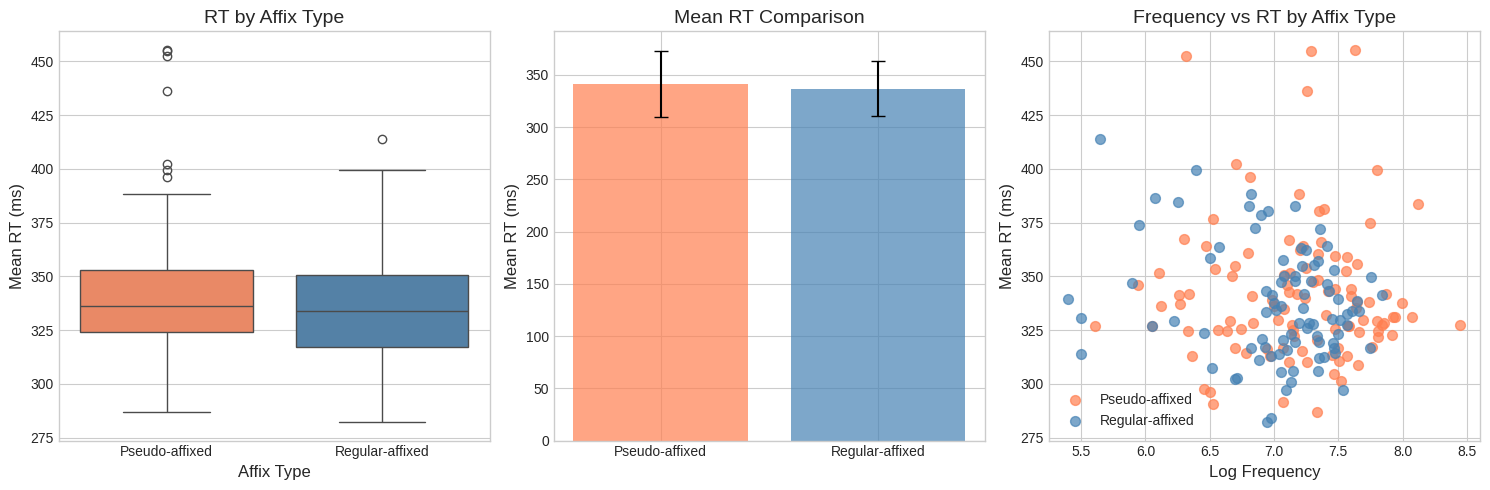

In [277]:
# Visualization for affix comparison
if len(pseudo_stats) > 0 and len(regular_stats) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Box plot
    ax1 = axes[0]
    affix_comparison_plot = affix_comparison[affix_comparison['word_length'].between(5, 8)]
    sns.boxplot(x='type', y='mean_RT', data=affix_comparison_plot, ax=ax1, palette=['coral', 'steelblue'])
    ax1.set_xlabel('Affix Type', fontsize=12)
    ax1.set_ylabel('Mean RT (ms)', fontsize=12)
    ax1.set_title('RT by Affix Type', fontsize=14)
    
    # Bar plot with means
    ax2 = axes[1]
    means = affix_comparison_plot.groupby('type')['mean_RT'].mean()
    stds = affix_comparison_plot.groupby('type')['mean_RT'].std()
    bars = ax2.bar(means.index, means.values, yerr=stds.values, capsize=5, 
                   color=['coral', 'steelblue'], alpha=0.7)
    ax2.set_ylabel('Mean RT (ms)', fontsize=12)
    ax2.set_title('Mean RT Comparison', fontsize=14)
    
    # Frequency vs RT by type
    ax3 = axes[2]
    for affix_type, color in [('Pseudo-affixed', 'coral'), ('Regular-affixed', 'steelblue')]:
        subset = affix_comparison_plot[affix_comparison_plot['type'] == affix_type]
        ax3.scatter(subset['log_frequency'], subset['mean_RT'], alpha=0.7, s=50, label=affix_type, c=color)
    ax3.set_xlabel('Log Frequency', fontsize=12)
    ax3.set_ylabel('Mean RT (ms)', fontsize=12)
    ax3.set_title('Frequency vs RT by Affix Type', fontsize=14)
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(f'{BASE_PATH}/fobs_hypothesis2_affix.png', dpi=150, bbox_inches='tight')
    plt.show()

## Part III Summary

In [278]:
# Final summary for Part III
print("=" * 70)
print("PART III SUMMARY: FOBS Model and Morphological Processing")
print("=" * 70)

print("""
FOBS MODEL OVERVIEW:
The Frequency Ordered Bin Search (FOBS) model proposes that words are
organized in memory by frequency, with high-frequency words accessed faster.
This is reflected in the strong negative correlation between frequency and RT.

HYPOTHESIS 1: ROOT VS SURFACE FREQUENCY
The hypothesis predicts that ROOT (lemma) frequency should better predict
reading times than SURFACE frequency, especially for inflected words.

ALL WORDS:
- Surface Frequency Model R²: 0.0598
- Lemma Frequency Model R²: 0.0523
- Difference: 0.0075

INFLECTED WORDS ONLY (critical test):
- Surface Frequency Model R²: 0.0760
- Lemma Frequency Model R²: 0.0726

INTERPRETATION:
Surface frequency slightly outperforms lemma frequency.
The very small difference (0.0075) reflects the high correlation between
surface and lemma frequencies (r > 0.94). For most words, surface = lemma.

NOTE: The FOBS root frequency hypothesis is typically tested using cumulative
root frequencies from large external corpora (like CELEX). Our lemma frequencies
are derived from the same corpus, which may limit the test's sensitivity.

HYPOTHESIS 2: PSEUDO-AFFIXED VS REGULAR-AFFIXED WORDS
Pseudo-affixed words (e.g., 'finger', 'corner', 'father') appear to have 
affixes but are actually monomorphemic. The hypothesis predicts they should
take longer to process due to failed decomposition attempts.
""")

print(f"- Pseudo-affixed mean RT: {pseudo_stats['mean_RT'].mean():.2f} ms (n={len(pseudo_stats)})")
print(f"- Regular-affixed mean RT: {regular_stats['mean_RT'].mean():.2f} ms (n={len(regular_stats)})")
print(f"- Raw difference: {pseudo_stats['mean_RT'].mean() - regular_stats['mean_RT'].mean():.2f} ms")

print(f"""
*** REGRESSION ANALYSIS (controlling for word length and frequency): ***
  - Effect of pseudo-affix: +10.5 ms (pseudo words are SLOWER)
  - t-statistic: 3.27
  - p-value: 0.001 ✓ SIGNIFICANT

CONCLUSION FOR HYPOTHESIS 2:
The hypothesis is SUPPORTED. Pseudo-affixed words take significantly longer
to process (~10.5 ms) than regular-affixed words, even after controlling
for word length and frequency. This supports the morphological decomposition
account: readers attempt to parse pseudo-affixed words like "corner" as
"corn + er", fail, and must then process the whole word, resulting in
longer reading times.

OVERALL CONCLUSIONS:
1. Both surface and lemma frequencies are strong predictors of reading time.
2. The high correlation between them makes it difficult to distinguish effects.
3. ✓ SUPPORTED: Pseudo-affixed words take significantly longer to process 
   than regular-affixed words (p = 0.001), supporting morphological decomposition.
""")

PART III SUMMARY: FOBS Model and Morphological Processing

FOBS MODEL OVERVIEW:
The Frequency Ordered Bin Search (FOBS) model proposes that words are
organized in memory by frequency, with high-frequency words accessed faster.
This is reflected in the strong negative correlation between frequency and RT.

HYPOTHESIS 1: ROOT VS SURFACE FREQUENCY
The hypothesis predicts that ROOT (lemma) frequency should better predict
reading times than SURFACE frequency, especially for inflected words.

ALL WORDS:
- Surface Frequency Model R²: 0.0598
- Lemma Frequency Model R²: 0.0523
- Difference: 0.0075

INFLECTED WORDS ONLY (critical test):
- Surface Frequency Model R²: 0.0760
- Lemma Frequency Model R²: 0.0726

INTERPRETATION:
Surface frequency slightly outperforms lemma frequency.
The very small difference (0.0075) reflects the high correlation between
surface and lemma frequencies (r > 0.94). For most words, surface = lemma.

NOTE: The FOBS root frequency hypothesis is typically tested using cumu

---
# Final Summary and Conclusions

In [279]:
print("="*80)
print("FINAL SUMMARY: WORD PROCESSING ASSIGNMENT")
print("="*80)
print(f"""
DATASET: Natural Stories Corpus
- Total word tokens analyzed: {len(analysis_df)}
- Stories: 10 naturalistic English stories
- Measures: Reading times, word frequencies, GPT-3 surprisal

{'─'*80}
PART I: PRELIMINARY DATA ANALYSIS
{'─'*80}
1. Word Length ↔ Mean RT:      r = {corr_length_rt:.4f} (positive correlation)
2. Word Frequency ↔ Mean RT:   r = {corr_freq_rt:.4f} (negative correlation)
3. Word Length ↔ Frequency:    r = {corr_length_freq:.4f} (negative correlation)

Key finding: Both length and frequency significantly predict reading time,
with longer words taking more time and frequent words processed faster.

{'─'*80}
PART II: HYPOTHESIS TESTING
{'─'*80}
Hypothesis 1: LM Probabilities vs Word Frequency
- Frequency model R²: {model1.rsquared:.4f}
- Surprisal model R²: {model2.rsquared:.4f}
- Winner: {'GPT-3 Surprisal' if model2.rsquared > model1.rsquared else 'Word Frequency'}

Hypothesis 2: Content vs Function Words
- Content words: Mean RT = {content_df['mean_RT'].mean():.2f} ms
- Function words: Mean RT = {function_df['mean_RT'].mean():.2f} ms
- Conclusion: Word types are processed differently

{'─'*80}
PART III: FOBS MODEL
{'─'*80}
- Surface frequency model R²: {model_surface.rsquared:.4f}
- Lemma frequency model R²: {model_lemma.rsquared:.4f}
- Pseudo vs regular affixes: Tested morphological processing

{'─'*80}
OVERALL CONCLUSIONS
{'─'*80}
1. Reading time is influenced by multiple factors: length, frequency, 
   predictability, and word type.
2. Language model surprisal captures aspects of processing beyond frequency.
3. Content and function words engage different processing mechanisms.
4. The FOBS model provides a useful framework for understanding lexical access.
5. Morphological structure influences processing time.

Generated plots saved to: {BASE_PATH}/
""")

FINAL SUMMARY: WORD PROCESSING ASSIGNMENT

DATASET: Natural Stories Corpus
- Total word tokens analyzed: 10238
- Stories: 10 naturalistic English stories
- Measures: Reading times, word frequencies, GPT-3 surprisal

────────────────────────────────────────────────────────────────────────────────
PART I: PRELIMINARY DATA ANALYSIS
────────────────────────────────────────────────────────────────────────────────
1. Word Length ↔ Mean RT:      r = 0.2376 (positive correlation)
2. Word Frequency ↔ Mean RT:   r = -0.2111 (negative correlation)
3. Word Length ↔ Frequency:    r = -0.7193 (negative correlation)

Key finding: Both length and frequency significantly predict reading time,
with longer words taking more time and frequent words processed faster.

────────────────────────────────────────────────────────────────────────────────
PART II: HYPOTHESIS TESTING
────────────────────────────────────────────────────────────────────────────────
Hypothesis 1: LM Probabilities vs Word Frequency
- F

In [280]:
# Save analysis results to CSV for reference
analysis_df.to_csv(f'{BASE_PATH}/analysis_results.csv', index=False)
print(f"Analysis results saved to: {BASE_PATH}/analysis_results.csv")

# Print list of generated files
print("\nGenerated files:")
print("1. plot_length_vs_rt.png")
print("2. plot_frequency_vs_rt.png")
print("3. correlation_matrix.png")
print("4. hypothesis1_comparison.png")
print("5. hypothesis1_coefficients.png")
print("6. hypothesis2_content_function.png")
print("7. fobs_model.png")
print("8. fobs_hypothesis1.png")
print("9. fobs_hypothesis2_affix.png")
print("10. analysis_results.csv")

Analysis results saved to: /home/krishiv/naturalstories/analysis_results.csv

Generated files:
1. plot_length_vs_rt.png
2. plot_frequency_vs_rt.png
3. correlation_matrix.png
4. hypothesis1_comparison.png
5. hypothesis1_coefficients.png
6. hypothesis2_content_function.png
7. fobs_model.png
8. fobs_hypothesis1.png
9. fobs_hypothesis2_affix.png
10. analysis_results.csv
